In [ ]:
# Packages
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd

In [ ]:
def get_news_urls(links_site):
    '''scrape the html of the site'''
    resp = requests.get(links_site)
 
    if not resp.ok:
        return None
 
    html = resp.content
 
    '''convert html to BeautifulSoup object'''
    soup = BeautifulSoup(html , 'lxml')
 
    '''get list of all links on webpage'''
    links = soup.find_all('a')
 
    urls = [link.get('href') for link in links]
    urls = [url for url in urls if url is not None]
 
    '''Filter the list of urls to just the news articles'''
    news_urls = [url for url in urls if '/article/' in url]
 
    return news_urls

In [ ]:
def scrape_news_text(news_url):
 
    news_html = requests.get(news_url).content
 
    '''convert html to BeautifulSoup object'''
    news_soup = BeautifulSoup(news_html , 'lxml')
 
    paragraphs = [par.text for par in news_soup.find_all('p')]
    news_text = '\n'.join(paragraphs)
    print("Finished scrapping: ", news_url)
 
    return news_text

In [ ]:
def scrape_all_articles(ticker , upper_page_limit = 5):
 
    landing_site = 'http://www.nasdaq.com/symbol/' + ticker + '/news-headlines'
 
    all_news_urls = get_news_urls(landing_site)
 
    current_urls_list = all_news_urls.copy()
 
    index = 2
 
    '''Loop through each sequential page, scraping the links from each'''
    while (current_urls_list is not None) and (current_urls_list != []) and \
        (index <= upper_page_limit):
 
        '''Construct URL for page in loop based off index'''
        current_site = landing_site + '?page=' + str(index)
        current_urls_list = get_news_urls(current_site)
 
        '''Append current webpage's list of urls to all_news_urls'''
        all_news_urls = all_news_urls + current_urls_list
 
        index = index + 1
        print("Done processing page: ", index)
 
    all_news_urls = list(set(all_news_urls))
 
    '''Now, we have a list of urls, we need to actually scrape the text'''
    all_articles = [scrape_news_text(news_url) for news_url in all_news_urls]
 
    return all_articles

In [ ]:
def save_articles_to_files(articles, ticker):
    article_counter = 0
    for article in articles: 
        article_file = ticker + str(article_counter) + '.txt'
        file_name = os.path.join('article_data', ticker, article_file)

        f = open(file_name, 'w')
        f.write(article)
        f.close()
        article_counter += 1
        print("Processed Article Number: ", article_counter)


In [ ]:
def get_processed_articles(articles):
    ad_string = "Enter up to 25 symbols separated by commas or spaces in the text box"
    intro = "Join the Nasdaq Community today and get free, instant access to portfolios, stock ratings, real-time alerts, and more!"
    processed_results = []
    for a in articles: 
        ad_string_pos = a.find(ad_string)
        intro_pos = a.find(intro)
        start_index = intro_pos + len(intro)
        end_index = ad_string_pos

        processed_results.append(a[start_index:end_index])
    
    return processed_results

In [ ]:
def get_all_articles(tickers, num_pages_to_read):
    all_articles = []
    for ticker in tickers:
        raw_articles = scrape_all_articles(ticker, num_pages_to_read)
        processed_articles = get_processed_articles(raw_articles)
        all_articles += processed_articles 
        print("Finished processing articles for: ", ticker)
    return all_articles


In [79]:
def get_company_set(article, tickers):
    words_found = set([])
    ticker_set = set(tickers)
    article = article.split()
    for word in article:
        if word in ticker_set: 
            words_found.add(word)
    return words_found 
        
    

In [81]:
def update_graph(edge_graph, company_set):
    pairs = itertools.combinations(company_set, 2)

    for pair in pairs: 
        if pair in edge_graph or (pair[1], pair[0]) in edge_graph:
            processed_pair = pair if pair in edge_graph else (pair[1], pair[0])
            edge_graph[processed_pair] += 1

In [22]:
def read_articles_from_disk(data_directories):
    counter = 0
    articles = []
    for directory in data_directories: 
        file_list = os.listdir(directory)
        files_to_read = [os.path.join(directory, file) for file in file_list]
        for file in files_to_read: 
            with open(file, 'r') as content_file:
                content = content_file.read()
                articles.append(content)
    return articles
    

In [68]:
directory_names = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DOW', 'GOOGL', 'GS', 'HD', 'IBM', 'KO', 'MMM', 'MSFT', 'NFLX', 'XOM']
root_data_dir = 'article_data'
data_directories = [os.path.join(root_data_dir, d) for d in directory_names]

all_articles = set(read_articles_from_disk(data_directories))

In [100]:
s_p_500 = [s for s in pd.read_csv('constituents.csv', header=0)['Symbol']]
s_p_500.remove('A')
s_p_500.remove('GOOG')
s_p_500.remove('T')

In [101]:
import itertools 
import random 
edges = itertools.combinations(s_p_500, 2)
edge_graph = {e:0 for e in edges}

for article in all_articles:
    company_set = get_company_set(article, s_p_500)
    update_graph(edge_graph, company_set)

In [102]:
results = sorted([(v, k) for k, v in edge_graph.items()], reverse=True)
results

[(455, ('AMZN', 'AAPL')),
 (439, ('GOOGL', 'AMZN')),
 (344, ('GOOGL', 'AAPL')),
 (342, ('CVX', 'XOM')),
 (340, ('AMZN', 'MSFT')),
 (323, ('AMZN', 'NFLX')),
 (300, ('GOOGL', 'FB')),
 (300, ('AAPL', 'MSFT')),
 (290, ('AAPL', 'NFLX')),
 (278, ('AMZN', 'FB')),
 (249, ('GOOGL', 'MSFT')),
 (243, ('NFLX', 'DIS')),
 (216, ('AAPL', 'FB')),
 (197, ('GOOGL', 'NFLX')),
 (184, ('GS', 'MS')),
 (182, ('FB', 'NFLX')),
 (175, ('AMZN', 'WMT')),
 (173, ('GS', 'JPM')),
 (163, ('FB', 'MSFT')),
 (163, ('BA', 'CAT')),
 (163, ('AMZN', 'DIS')),
 (161, ('AAPL', 'DIS')),
 (136, ('KO', 'PEP')),
 (135, ('BAC', 'GS')),
 (132, ('CVX', 'COP')),
 (128, ('HD', 'LOW')),
 (127, ('COP', 'XOM')),
 (127, ('BAC', 'JPM')),
 (124, ('MMM', 'CAT')),
 (124, ('AAPL', 'CSCO')),
 (123, ('IBM', 'MSFT')),
 (115, ('AAPL', 'BA')),
 (113, ('AAPL', 'INTC')),
 (111, ('C', 'GS')),
 (111, ('AMZN', 'HD')),
 (110, ('CSCO', 'MSFT')),
 (102, ('HD', 'WMT')),
 (102, ('CVX', 'OXY')),
 (102, ('C', 'JPM')),
 (102, ('AAPL', 'QCOM')),
 (102, ('AAPL', '

('MMM', 'AOS')
('MMM', 'ABT')
('MMM', 'ABBV')
('MMM', 'ACN')
('MMM', 'ATVI')
('MMM', 'AYI')
('MMM', 'ADBE')
('MMM', 'AAP')
('MMM', 'AMD')
('MMM', 'AES')
('MMM', 'AET')
('MMM', 'AMG')
('MMM', 'AFL')
('MMM', 'APD')
('MMM', 'AKAM')
('MMM', 'ALK')
('MMM', 'ALB')
('MMM', 'ARE')
('MMM', 'ALXN')
('MMM', 'ALGN')
('MMM', 'ALLE')
('MMM', 'AGN')
('MMM', 'ADS')
('MMM', 'LNT')
('MMM', 'ALL')
('MMM', 'GOOGL')
('MMM', 'MO')
('MMM', 'AMZN')
('MMM', 'AEE')
('MMM', 'AAL')
('MMM', 'AEP')
('MMM', 'AXP')
('MMM', 'AIG')
('MMM', 'AMT')
('MMM', 'AWK')
('MMM', 'AMP')
('MMM', 'ABC')
('MMM', 'AME')
('MMM', 'AMGN')
('MMM', 'APH')
('MMM', 'APC')
('MMM', 'ADI')
('MMM', 'ANDV')
('MMM', 'ANSS')
('MMM', 'ANTM')
('MMM', 'AON')
('MMM', 'APA')
('MMM', 'AIV')
('MMM', 'AAPL')
('MMM', 'AMAT')
('MMM', 'APTV')
('MMM', 'ADM')
('MMM', 'ARNC')
('MMM', 'AJG')
('MMM', 'AIZ')
('MMM', 'ADSK')
('MMM', 'ADP')
('MMM', 'AZO')
('MMM', 'AVB')
('MMM', 'AVY')
('MMM', 'BHGE')
('MMM', 'BLL')
('MMM', 'BAC')
('MMM', 'BAX')
('MMM', 'BBT')
('MMM'

('ATVI', 'WRK')
('ATVI', 'WY')
('ATVI', 'WHR')
('ATVI', 'WMB')
('ATVI', 'WLTW')
('ATVI', 'WYN')
('ATVI', 'WYNN')
('ATVI', 'XEL')
('ATVI', 'XRX')
('ATVI', 'XLNX')
('ATVI', 'XL')
('ATVI', 'XYL')
('ATVI', 'YUM')
('ATVI', 'ZBH')
('ATVI', 'ZION')
('ATVI', 'ZTS')
('AYI', 'ADBE')
('AYI', 'AAP')
('AYI', 'AMD')
('AYI', 'AES')
('AYI', 'AET')
('AYI', 'AMG')
('AYI', 'AFL')
('AYI', 'APD')
('AYI', 'AKAM')
('AYI', 'ALK')
('AYI', 'ALB')
('AYI', 'ARE')
('AYI', 'ALXN')
('AYI', 'ALGN')
('AYI', 'ALLE')
('AYI', 'AGN')
('AYI', 'ADS')
('AYI', 'LNT')
('AYI', 'ALL')
('AYI', 'GOOGL')
('AYI', 'MO')
('AYI', 'AMZN')
('AYI', 'AEE')
('AYI', 'AAL')
('AYI', 'AEP')
('AYI', 'AXP')
('AYI', 'AIG')
('AYI', 'AMT')
('AYI', 'AWK')
('AYI', 'AMP')
('AYI', 'ABC')
('AYI', 'AME')
('AYI', 'AMGN')
('AYI', 'APH')
('AYI', 'APC')
('AYI', 'ADI')
('AYI', 'ANDV')
('AYI', 'ANSS')
('AYI', 'ANTM')
('AYI', 'AON')
('AYI', 'APA')
('AYI', 'AIV')
('AYI', 'AAPL')
('AYI', 'AMAT')
('AYI', 'APTV')
('AYI', 'ADM')
('AYI', 'ARNC')
('AYI', 'AJG')
('AYI',

('AET', 'AAL')
('AET', 'AEP')
('AET', 'AXP')
('AET', 'AIG')
('AET', 'AMT')
('AET', 'AWK')
('AET', 'AMP')
('AET', 'ABC')
('AET', 'AME')
('AET', 'AMGN')
('AET', 'APH')
('AET', 'APC')
('AET', 'ADI')
('AET', 'ANDV')
('AET', 'ANSS')
('AET', 'ANTM')
('AET', 'AON')
('AET', 'APA')
('AET', 'AIV')
('AET', 'AAPL')
('AET', 'AMAT')
('AET', 'APTV')
('AET', 'ADM')
('AET', 'ARNC')
('AET', 'AJG')
('AET', 'AIZ')
('AET', 'ADSK')
('AET', 'ADP')
('AET', 'AZO')
('AET', 'AVB')
('AET', 'AVY')
('AET', 'BHGE')
('AET', 'BLL')
('AET', 'BAC')
('AET', 'BAX')
('AET', 'BBT')
('AET', 'BDX')
('AET', 'BRK.B')
('AET', 'BBY')
('AET', 'BIIB')
('AET', 'BLK')
('AET', 'HRB')
('AET', 'BA')
('AET', 'BWA')
('AET', 'BXP')
('AET', 'BSX')
('AET', 'BHF')
('AET', 'BMY')
('AET', 'AVGO')
('AET', 'BF.B')
('AET', 'CHRW')
('AET', 'CA')
('AET', 'COG')
('AET', 'CDNS')
('AET', 'CPB')
('AET', 'COF')
('AET', 'CAH')
('AET', 'KMX')
('AET', 'CCL')
('AET', 'CAT')
('AET', 'CBOE')
('AET', 'CBG')
('AET', 'CBS')
('AET', 'CELG')
('AET', 'CNC')
('AET', 

('ALB', 'C')
('ALB', 'CFG')
('ALB', 'CTXS')
('ALB', 'CME')
('ALB', 'CMS')
('ALB', 'KO')
('ALB', 'CTSH')
('ALB', 'CL')
('ALB', 'CMCSA')
('ALB', 'CMA')
('ALB', 'CAG')
('ALB', 'CXO')
('ALB', 'COP')
('ALB', 'ED')
('ALB', 'STZ')
('ALB', 'GLW')
('ALB', 'COST')
('ALB', 'COTY')
('ALB', 'CCI')
('ALB', 'CSRA')
('ALB', 'CSX')
('ALB', 'CMI')
('ALB', 'CVS')
('ALB', 'DHI')
('ALB', 'DHR')
('ALB', 'DRI')
('ALB', 'DVA')
('ALB', 'DE')
('ALB', 'DAL')
('ALB', 'XRAY')
('ALB', 'DVN')
('ALB', 'DLR')
('ALB', 'DFS')
('ALB', 'DISCA')
('ALB', 'DISCK')
('ALB', 'DISH')
('ALB', 'DG')
('ALB', 'DLTR')
('ALB', 'D')
('ALB', 'DOV')
('ALB', 'DWDP')
('ALB', 'DPS')
('ALB', 'DTE')
('ALB', 'DUK')
('ALB', 'DRE')
('ALB', 'DXC')
('ALB', 'ETFC')
('ALB', 'EMN')
('ALB', 'ETN')
('ALB', 'EBAY')
('ALB', 'ECL')
('ALB', 'EIX')
('ALB', 'EW')
('ALB', 'EA')
('ALB', 'EMR')
('ALB', 'ETR')
('ALB', 'EVHC')
('ALB', 'EOG')
('ALB', 'EQT')
('ALB', 'EFX')
('ALB', 'EQIX')
('ALB', 'EQR')
('ALB', 'ESS')
('ALB', 'EL')
('ALB', 'RE')
('ALB', 'ES')
('ALB

('AGN', 'NDAQ')
('AGN', 'NOV')
('AGN', 'NAVI')
('AGN', 'NTAP')
('AGN', 'NFLX')
('AGN', 'NWL')
('AGN', 'NFX')
('AGN', 'NEM')
('AGN', 'NWSA')
('AGN', 'NWS')
('AGN', 'NEE')
('AGN', 'NLSN')
('AGN', 'NKE')
('AGN', 'NI')
('AGN', 'NBL')
('AGN', 'JWN')
('AGN', 'NSC')
('AGN', 'NTRS')
('AGN', 'NOC')
('AGN', 'NCLH')
('AGN', 'NRG')
('AGN', 'NUE')
('AGN', 'NVDA')
('AGN', 'ORLY')
('AGN', 'OXY')
('AGN', 'OMC')
('AGN', 'OKE')
('AGN', 'ORCL')
('AGN', 'PCAR')
('AGN', 'PKG')
('AGN', 'PH')
('AGN', 'PDCO')
('AGN', 'PAYX')
('AGN', 'PYPL')
('AGN', 'PNR')
('AGN', 'PBCT')
('AGN', 'PEP')
('AGN', 'PKI')
('AGN', 'PRGO')
('AGN', 'PFE')
('AGN', 'PCG')
('AGN', 'PM')
('AGN', 'PSX')
('AGN', 'PNW')
('AGN', 'PXD')
('AGN', 'PNC')
('AGN', 'RL')
('AGN', 'PPG')
('AGN', 'PPL')
('AGN', 'PX')
('AGN', 'PCLN')
('AGN', 'PFG')
('AGN', 'PG')
('AGN', 'PGR')
('AGN', 'PLD')
('AGN', 'PRU')
('AGN', 'PEG')
('AGN', 'PSA')
('AGN', 'PHM')
('AGN', 'PVH')
('AGN', 'QRVO')
('AGN', 'QCOM')
('AGN', 'PWR')
('AGN', 'DGX')
('AGN', 'RRC')
('AGN', 'RJ

('AMZN', 'PYPL')
('AMZN', 'PNR')
('AMZN', 'PBCT')
('AMZN', 'PEP')
('AMZN', 'PKI')
('AMZN', 'PRGO')
('AMZN', 'PFE')
('AMZN', 'PCG')
('AMZN', 'PM')
('AMZN', 'PSX')
('AMZN', 'PNW')
('AMZN', 'PXD')
('AMZN', 'PNC')
('AMZN', 'RL')
('AMZN', 'PPG')
('AMZN', 'PPL')
('AMZN', 'PX')
('AMZN', 'PCLN')
('AMZN', 'PFG')
('AMZN', 'PG')
('AMZN', 'PGR')
('AMZN', 'PLD')
('AMZN', 'PRU')
('AMZN', 'PEG')
('AMZN', 'PSA')
('AMZN', 'PHM')
('AMZN', 'PVH')
('AMZN', 'QRVO')
('AMZN', 'QCOM')
('AMZN', 'PWR')
('AMZN', 'DGX')
('AMZN', 'RRC')
('AMZN', 'RJF')
('AMZN', 'RTN')
('AMZN', 'O')
('AMZN', 'RHT')
('AMZN', 'REG')
('AMZN', 'REGN')
('AMZN', 'RF')
('AMZN', 'RSG')
('AMZN', 'RMD')
('AMZN', 'RHI')
('AMZN', 'ROK')
('AMZN', 'COL')
('AMZN', 'ROP')
('AMZN', 'ROST')
('AMZN', 'RCL')
('AMZN', 'SPGI')
('AMZN', 'CRM')
('AMZN', 'SBAC')
('AMZN', 'SCG')
('AMZN', 'SLB')
('AMZN', 'SNI')
('AMZN', 'STX')
('AMZN', 'SEE')
('AMZN', 'SRE')
('AMZN', 'SHW')
('AMZN', 'SIG')
('AMZN', 'SPG')
('AMZN', 'SWKS')
('AMZN', 'SLG')
('AMZN', 'SNA')
('AM

('AWK', 'BBY')
('AWK', 'BIIB')
('AWK', 'BLK')
('AWK', 'HRB')
('AWK', 'BA')
('AWK', 'BWA')
('AWK', 'BXP')
('AWK', 'BSX')
('AWK', 'BHF')
('AWK', 'BMY')
('AWK', 'AVGO')
('AWK', 'BF.B')
('AWK', 'CHRW')
('AWK', 'CA')
('AWK', 'COG')
('AWK', 'CDNS')
('AWK', 'CPB')
('AWK', 'COF')
('AWK', 'CAH')
('AWK', 'KMX')
('AWK', 'CCL')
('AWK', 'CAT')
('AWK', 'CBOE')
('AWK', 'CBG')
('AWK', 'CBS')
('AWK', 'CELG')
('AWK', 'CNC')
('AWK', 'CNP')
('AWK', 'CTL')
('AWK', 'CERN')
('AWK', 'CF')
('AWK', 'SCHW')
('AWK', 'CHTR')
('AWK', 'CHK')
('AWK', 'CVX')
('AWK', 'CMG')
('AWK', 'CB')
('AWK', 'CHD')
('AWK', 'CI')
('AWK', 'XEC')
('AWK', 'CINF')
('AWK', 'CTAS')
('AWK', 'CSCO')
('AWK', 'C')
('AWK', 'CFG')
('AWK', 'CTXS')
('AWK', 'CME')
('AWK', 'CMS')
('AWK', 'KO')
('AWK', 'CTSH')
('AWK', 'CL')
('AWK', 'CMCSA')
('AWK', 'CMA')
('AWK', 'CAG')
('AWK', 'CXO')
('AWK', 'COP')
('AWK', 'ED')
('AWK', 'STZ')
('AWK', 'GLW')
('AWK', 'COST')
('AWK', 'COTY')
('AWK', 'CCI')
('AWK', 'CSRA')
('AWK', 'CSX')
('AWK', 'CMI')
('AWK', 'CVS')


('APC', 'MLM')
('APC', 'MAS')
('APC', 'MA')
('APC', 'MAT')
('APC', 'MKC')
('APC', 'MCD')
('APC', 'MCK')
('APC', 'MDT')
('APC', 'MRK')
('APC', 'MET')
('APC', 'MTD')
('APC', 'MGM')
('APC', 'KORS')
('APC', 'MCHP')
('APC', 'MU')
('APC', 'MSFT')
('APC', 'MAA')
('APC', 'MHK')
('APC', 'TAP')
('APC', 'MDLZ')
('APC', 'MON')
('APC', 'MNST')
('APC', 'MCO')
('APC', 'MS')
('APC', 'MSI')
('APC', 'MYL')
('APC', 'NDAQ')
('APC', 'NOV')
('APC', 'NAVI')
('APC', 'NTAP')
('APC', 'NFLX')
('APC', 'NWL')
('APC', 'NFX')
('APC', 'NEM')
('APC', 'NWSA')
('APC', 'NWS')
('APC', 'NEE')
('APC', 'NLSN')
('APC', 'NKE')
('APC', 'NI')
('APC', 'NBL')
('APC', 'JWN')
('APC', 'NSC')
('APC', 'NTRS')
('APC', 'NOC')
('APC', 'NCLH')
('APC', 'NRG')
('APC', 'NUE')
('APC', 'NVDA')
('APC', 'ORLY')
('APC', 'OXY')
('APC', 'OMC')
('APC', 'OKE')
('APC', 'ORCL')
('APC', 'PCAR')
('APC', 'PKG')
('APC', 'PH')
('APC', 'PDCO')
('APC', 'PAYX')
('APC', 'PYPL')
('APC', 'PNR')
('APC', 'PBCT')
('APC', 'PEP')
('APC', 'PKI')
('APC', 'PRGO')
('APC', 

('AIV', 'CHTR')
('AIV', 'CHK')
('AIV', 'CVX')
('AIV', 'CMG')
('AIV', 'CB')
('AIV', 'CHD')
('AIV', 'CI')
('AIV', 'XEC')
('AIV', 'CINF')
('AIV', 'CTAS')
('AIV', 'CSCO')
('AIV', 'C')
('AIV', 'CFG')
('AIV', 'CTXS')
('AIV', 'CME')
('AIV', 'CMS')
('AIV', 'KO')
('AIV', 'CTSH')
('AIV', 'CL')
('AIV', 'CMCSA')
('AIV', 'CMA')
('AIV', 'CAG')
('AIV', 'CXO')
('AIV', 'COP')
('AIV', 'ED')
('AIV', 'STZ')
('AIV', 'GLW')
('AIV', 'COST')
('AIV', 'COTY')
('AIV', 'CCI')
('AIV', 'CSRA')
('AIV', 'CSX')
('AIV', 'CMI')
('AIV', 'CVS')
('AIV', 'DHI')
('AIV', 'DHR')
('AIV', 'DRI')
('AIV', 'DVA')
('AIV', 'DE')
('AIV', 'DAL')
('AIV', 'XRAY')
('AIV', 'DVN')
('AIV', 'DLR')
('AIV', 'DFS')
('AIV', 'DISCA')
('AIV', 'DISCK')
('AIV', 'DISH')
('AIV', 'DG')
('AIV', 'DLTR')
('AIV', 'D')
('AIV', 'DOV')
('AIV', 'DWDP')
('AIV', 'DPS')
('AIV', 'DTE')
('AIV', 'DUK')
('AIV', 'DRE')
('AIV', 'DXC')
('AIV', 'ETFC')
('AIV', 'EMN')
('AIV', 'ETN')
('AIV', 'EBAY')
('AIV', 'ECL')
('AIV', 'EIX')
('AIV', 'EW')
('AIV', 'EA')
('AIV', 'EMR')
('

('AJG', 'SLB')
('AJG', 'SNI')
('AJG', 'STX')
('AJG', 'SEE')
('AJG', 'SRE')
('AJG', 'SHW')
('AJG', 'SIG')
('AJG', 'SPG')
('AJG', 'SWKS')
('AJG', 'SLG')
('AJG', 'SNA')
('AJG', 'SO')
('AJG', 'LUV')
('AJG', 'SWK')
('AJG', 'SBUX')
('AJG', 'STT')
('AJG', 'SRCL')
('AJG', 'SYK')
('AJG', 'STI')
('AJG', 'SYMC')
('AJG', 'SYF')
('AJG', 'SNPS')
('AJG', 'SYY')
('AJG', 'TROW')
('AJG', 'TPR')
('AJG', 'TGT')
('AJG', 'TEL')
('AJG', 'FTI')
('AJG', 'TXN')
('AJG', 'TXT')
('AJG', 'BK')
('AJG', 'CLX')
('AJG', 'COO')
('AJG', 'HSY')
('AJG', 'MOS')
('AJG', 'TRV')
('AJG', 'DIS')
('AJG', 'TMO')
('AJG', 'TIF')
('AJG', 'TWX')
('AJG', 'TJX')
('AJG', 'TMK')
('AJG', 'TSS')
('AJG', 'TSCO')
('AJG', 'TDG')
('AJG', 'TRIP')
('AJG', 'FOXA')
('AJG', 'FOX')
('AJG', 'TSN')
('AJG', 'USB')
('AJG', 'UDR')
('AJG', 'ULTA')
('AJG', 'UAA')
('AJG', 'UA')
('AJG', 'UNP')
('AJG', 'UAL')
('AJG', 'UNH')
('AJG', 'UPS')
('AJG', 'URI')
('AJG', 'UTX')
('AJG', 'UHS')
('AJG', 'UNM')
('AJG', 'VFC')
('AJG', 'VLO')
('AJG', 'VAR')
('AJG', 'VTR')
('A

('BHGE', 'MRK')
('BHGE', 'MET')
('BHGE', 'MTD')
('BHGE', 'MGM')
('BHGE', 'KORS')
('BHGE', 'MCHP')
('BHGE', 'MU')
('BHGE', 'MSFT')
('BHGE', 'MAA')
('BHGE', 'MHK')
('BHGE', 'TAP')
('BHGE', 'MDLZ')
('BHGE', 'MON')
('BHGE', 'MNST')
('BHGE', 'MCO')
('BHGE', 'MS')
('BHGE', 'MSI')
('BHGE', 'MYL')
('BHGE', 'NDAQ')
('BHGE', 'NOV')
('BHGE', 'NAVI')
('BHGE', 'NTAP')
('BHGE', 'NFLX')
('BHGE', 'NWL')
('BHGE', 'NFX')
('BHGE', 'NEM')
('BHGE', 'NWSA')
('BHGE', 'NWS')
('BHGE', 'NEE')
('BHGE', 'NLSN')
('BHGE', 'NKE')
('BHGE', 'NI')
('BHGE', 'NBL')
('BHGE', 'JWN')
('BHGE', 'NSC')
('BHGE', 'NTRS')
('BHGE', 'NOC')
('BHGE', 'NCLH')
('BHGE', 'NRG')
('BHGE', 'NUE')
('BHGE', 'NVDA')
('BHGE', 'ORLY')
('BHGE', 'OXY')
('BHGE', 'OMC')
('BHGE', 'OKE')
('BHGE', 'ORCL')
('BHGE', 'PCAR')
('BHGE', 'PKG')
('BHGE', 'PH')
('BHGE', 'PDCO')
('BHGE', 'PAYX')
('BHGE', 'PYPL')
('BHGE', 'PNR')
('BHGE', 'PBCT')
('BHGE', 'PEP')
('BHGE', 'PKI')
('BHGE', 'PRGO')
('BHGE', 'PFE')
('BHGE', 'PCG')
('BHGE', 'PM')
('BHGE', 'PSX')
('BHGE'

('BBY', 'IFF')
('BBY', 'INTU')
('BBY', 'ISRG')
('BBY', 'IVZ')
('BBY', 'IQV')
('BBY', 'IRM')
('BBY', 'JBHT')
('BBY', 'JEC')
('BBY', 'SJM')
('BBY', 'JNJ')
('BBY', 'JCI')
('BBY', 'JPM')
('BBY', 'JNPR')
('BBY', 'KSU')
('BBY', 'K')
('BBY', 'KEY')
('BBY', 'KMB')
('BBY', 'KIM')
('BBY', 'KMI')
('BBY', 'KLAC')
('BBY', 'KSS')
('BBY', 'KHC')
('BBY', 'KR')
('BBY', 'LB')
('BBY', 'LLL')
('BBY', 'LH')
('BBY', 'LRCX')
('BBY', 'LEG')
('BBY', 'LEN')
('BBY', 'LUK')
('BBY', 'LLY')
('BBY', 'LNC')
('BBY', 'LKQ')
('BBY', 'LMT')
('BBY', 'L')
('BBY', 'LOW')
('BBY', 'LYB')
('BBY', 'MTB')
('BBY', 'MAC')
('BBY', 'M')
('BBY', 'MRO')
('BBY', 'MPC')
('BBY', 'MAR')
('BBY', 'MMC')
('BBY', 'MLM')
('BBY', 'MAS')
('BBY', 'MA')
('BBY', 'MAT')
('BBY', 'MKC')
('BBY', 'MCD')
('BBY', 'MCK')
('BBY', 'MDT')
('BBY', 'MRK')
('BBY', 'MET')
('BBY', 'MTD')
('BBY', 'MGM')
('BBY', 'KORS')
('BBY', 'MCHP')
('BBY', 'MU')
('BBY', 'MSFT')
('BBY', 'MAA')
('BBY', 'MHK')
('BBY', 'TAP')
('BBY', 'MDLZ')
('BBY', 'MON')
('BBY', 'MNST')
('BBY', 'M

('BSX', 'ICE')
('BSX', 'IBM')
('BSX', 'IP')
('BSX', 'IPG')
('BSX', 'IFF')
('BSX', 'INTU')
('BSX', 'ISRG')
('BSX', 'IVZ')
('BSX', 'IQV')
('BSX', 'IRM')
('BSX', 'JBHT')
('BSX', 'JEC')
('BSX', 'SJM')
('BSX', 'JNJ')
('BSX', 'JCI')
('BSX', 'JPM')
('BSX', 'JNPR')
('BSX', 'KSU')
('BSX', 'K')
('BSX', 'KEY')
('BSX', 'KMB')
('BSX', 'KIM')
('BSX', 'KMI')
('BSX', 'KLAC')
('BSX', 'KSS')
('BSX', 'KHC')
('BSX', 'KR')
('BSX', 'LB')
('BSX', 'LLL')
('BSX', 'LH')
('BSX', 'LRCX')
('BSX', 'LEG')
('BSX', 'LEN')
('BSX', 'LUK')
('BSX', 'LLY')
('BSX', 'LNC')
('BSX', 'LKQ')
('BSX', 'LMT')
('BSX', 'L')
('BSX', 'LOW')
('BSX', 'LYB')
('BSX', 'MTB')
('BSX', 'MAC')
('BSX', 'M')
('BSX', 'MRO')
('BSX', 'MPC')
('BSX', 'MAR')
('BSX', 'MMC')
('BSX', 'MLM')
('BSX', 'MAS')
('BSX', 'MA')
('BSX', 'MAT')
('BSX', 'MKC')
('BSX', 'MCD')
('BSX', 'MCK')
('BSX', 'MDT')
('BSX', 'MRK')
('BSX', 'MET')
('BSX', 'MTD')
('BSX', 'MGM')
('BSX', 'KORS')
('BSX', 'MCHP')
('BSX', 'MU')
('BSX', 'MSFT')
('BSX', 'MAA')
('BSX', 'MHK')
('BSX', 'TAP'

('COG', 'MAR')
('COG', 'MMC')
('COG', 'MLM')
('COG', 'MAS')
('COG', 'MA')
('COG', 'MAT')
('COG', 'MKC')
('COG', 'MCD')
('COG', 'MCK')
('COG', 'MDT')
('COG', 'MRK')
('COG', 'MET')
('COG', 'MTD')
('COG', 'MGM')
('COG', 'KORS')
('COG', 'MCHP')
('COG', 'MU')
('COG', 'MSFT')
('COG', 'MAA')
('COG', 'MHK')
('COG', 'TAP')
('COG', 'MDLZ')
('COG', 'MON')
('COG', 'MNST')
('COG', 'MCO')
('COG', 'MS')
('COG', 'MSI')
('COG', 'MYL')
('COG', 'NDAQ')
('COG', 'NOV')
('COG', 'NAVI')
('COG', 'NTAP')
('COG', 'NFLX')
('COG', 'NWL')
('COG', 'NFX')
('COG', 'NEM')
('COG', 'NWSA')
('COG', 'NWS')
('COG', 'NEE')
('COG', 'NLSN')
('COG', 'NKE')
('COG', 'NI')
('COG', 'NBL')
('COG', 'JWN')
('COG', 'NSC')
('COG', 'NTRS')
('COG', 'NOC')
('COG', 'NCLH')
('COG', 'NRG')
('COG', 'NUE')
('COG', 'NVDA')
('COG', 'ORLY')
('COG', 'OXY')
('COG', 'OMC')
('COG', 'OKE')
('COG', 'ORCL')
('COG', 'PCAR')
('COG', 'PKG')
('COG', 'PH')
('COG', 'PDCO')
('COG', 'PAYX')
('COG', 'PYPL')
('COG', 'PNR')
('COG', 'PBCT')
('COG', 'PEP')
('COG', '

('CAT', 'RTN')
('CAT', 'O')
('CAT', 'RHT')
('CAT', 'REG')
('CAT', 'REGN')
('CAT', 'RF')
('CAT', 'RSG')
('CAT', 'RMD')
('CAT', 'RHI')
('CAT', 'ROK')
('CAT', 'COL')
('CAT', 'ROP')
('CAT', 'ROST')
('CAT', 'RCL')
('CAT', 'SPGI')
('CAT', 'CRM')
('CAT', 'SBAC')
('CAT', 'SCG')
('CAT', 'SLB')
('CAT', 'SNI')
('CAT', 'STX')
('CAT', 'SEE')
('CAT', 'SRE')
('CAT', 'SHW')
('CAT', 'SIG')
('CAT', 'SPG')
('CAT', 'SWKS')
('CAT', 'SLG')
('CAT', 'SNA')
('CAT', 'SO')
('CAT', 'LUV')
('CAT', 'SWK')
('CAT', 'SBUX')
('CAT', 'STT')
('CAT', 'SRCL')
('CAT', 'SYK')
('CAT', 'STI')
('CAT', 'SYMC')
('CAT', 'SYF')
('CAT', 'SNPS')
('CAT', 'SYY')
('CAT', 'TROW')
('CAT', 'TPR')
('CAT', 'TGT')
('CAT', 'TEL')
('CAT', 'FTI')
('CAT', 'TXN')
('CAT', 'TXT')
('CAT', 'BK')
('CAT', 'CLX')
('CAT', 'COO')
('CAT', 'HSY')
('CAT', 'MOS')
('CAT', 'TRV')
('CAT', 'DIS')
('CAT', 'TMO')
('CAT', 'TIF')
('CAT', 'TWX')
('CAT', 'TJX')
('CAT', 'TMK')
('CAT', 'TSS')
('CAT', 'TSCO')
('CAT', 'TDG')
('CAT', 'TRIP')
('CAT', 'FOXA')
('CAT', 'FOX')
('

('CERN', 'STZ')
('CERN', 'GLW')
('CERN', 'COST')
('CERN', 'COTY')
('CERN', 'CCI')
('CERN', 'CSRA')
('CERN', 'CSX')
('CERN', 'CMI')
('CERN', 'CVS')
('CERN', 'DHI')
('CERN', 'DHR')
('CERN', 'DRI')
('CERN', 'DVA')
('CERN', 'DE')
('CERN', 'DAL')
('CERN', 'XRAY')
('CERN', 'DVN')
('CERN', 'DLR')
('CERN', 'DFS')
('CERN', 'DISCA')
('CERN', 'DISCK')
('CERN', 'DISH')
('CERN', 'DG')
('CERN', 'DLTR')
('CERN', 'D')
('CERN', 'DOV')
('CERN', 'DWDP')
('CERN', 'DPS')
('CERN', 'DTE')
('CERN', 'DUK')
('CERN', 'DRE')
('CERN', 'DXC')
('CERN', 'ETFC')
('CERN', 'EMN')
('CERN', 'ETN')
('CERN', 'EBAY')
('CERN', 'ECL')
('CERN', 'EIX')
('CERN', 'EW')
('CERN', 'EA')
('CERN', 'EMR')
('CERN', 'ETR')
('CERN', 'EVHC')
('CERN', 'EOG')
('CERN', 'EQT')
('CERN', 'EFX')
('CERN', 'EQIX')
('CERN', 'EQR')
('CERN', 'ESS')
('CERN', 'EL')
('CERN', 'RE')
('CERN', 'ES')
('CERN', 'EXC')
('CERN', 'EXPE')
('CERN', 'EXPD')
('CERN', 'ESRX')
('CERN', 'EXR')
('CERN', 'XOM')
('CERN', 'FFIV')
('CERN', 'FB')
('CERN', 'FAST')
('CERN', 'FRT'

('CB', 'WY')
('CB', 'WHR')
('CB', 'WMB')
('CB', 'WLTW')
('CB', 'WYN')
('CB', 'WYNN')
('CB', 'XEL')
('CB', 'XRX')
('CB', 'XLNX')
('CB', 'XL')
('CB', 'XYL')
('CB', 'YUM')
('CB', 'ZBH')
('CB', 'ZION')
('CB', 'ZTS')
('CHD', 'CI')
('CHD', 'XEC')
('CHD', 'CINF')
('CHD', 'CTAS')
('CHD', 'CSCO')
('CHD', 'C')
('CHD', 'CFG')
('CHD', 'CTXS')
('CHD', 'CME')
('CHD', 'CMS')
('CHD', 'KO')
('CHD', 'CTSH')
('CHD', 'CL')
('CHD', 'CMCSA')
('CHD', 'CMA')
('CHD', 'CAG')
('CHD', 'CXO')
('CHD', 'COP')
('CHD', 'ED')
('CHD', 'STZ')
('CHD', 'GLW')
('CHD', 'COST')
('CHD', 'COTY')
('CHD', 'CCI')
('CHD', 'CSRA')
('CHD', 'CSX')
('CHD', 'CMI')
('CHD', 'CVS')
('CHD', 'DHI')
('CHD', 'DHR')
('CHD', 'DRI')
('CHD', 'DVA')
('CHD', 'DE')
('CHD', 'DAL')
('CHD', 'XRAY')
('CHD', 'DVN')
('CHD', 'DLR')
('CHD', 'DFS')
('CHD', 'DISCA')
('CHD', 'DISCK')
('CHD', 'DISH')
('CHD', 'DG')
('CHD', 'DLTR')
('CHD', 'D')
('CHD', 'DOV')
('CHD', 'DWDP')
('CHD', 'DPS')
('CHD', 'DTE')
('CHD', 'DUK')
('CHD', 'DRE')
('CHD', 'DXC')
('CHD', 'ETFC')

('CTXS', 'MAT')
('CTXS', 'MKC')
('CTXS', 'MCD')
('CTXS', 'MCK')
('CTXS', 'MDT')
('CTXS', 'MRK')
('CTXS', 'MET')
('CTXS', 'MTD')
('CTXS', 'MGM')
('CTXS', 'KORS')
('CTXS', 'MCHP')
('CTXS', 'MU')
('CTXS', 'MSFT')
('CTXS', 'MAA')
('CTXS', 'MHK')
('CTXS', 'TAP')
('CTXS', 'MDLZ')
('CTXS', 'MON')
('CTXS', 'MNST')
('CTXS', 'MCO')
('CTXS', 'MS')
('CTXS', 'MSI')
('CTXS', 'MYL')
('CTXS', 'NDAQ')
('CTXS', 'NOV')
('CTXS', 'NAVI')
('CTXS', 'NTAP')
('CTXS', 'NFLX')
('CTXS', 'NWL')
('CTXS', 'NFX')
('CTXS', 'NEM')
('CTXS', 'NWSA')
('CTXS', 'NWS')
('CTXS', 'NEE')
('CTXS', 'NLSN')
('CTXS', 'NKE')
('CTXS', 'NI')
('CTXS', 'NBL')
('CTXS', 'JWN')
('CTXS', 'NSC')
('CTXS', 'NTRS')
('CTXS', 'NOC')
('CTXS', 'NCLH')
('CTXS', 'NRG')
('CTXS', 'NUE')
('CTXS', 'NVDA')
('CTXS', 'ORLY')
('CTXS', 'OXY')
('CTXS', 'OMC')
('CTXS', 'OKE')
('CTXS', 'ORCL')
('CTXS', 'PCAR')
('CTXS', 'PKG')
('CTXS', 'PH')
('CTXS', 'PDCO')
('CTXS', 'PAYX')
('CTXS', 'PYPL')
('CTXS', 'PNR')
('CTXS', 'PBCT')
('CTXS', 'PEP')
('CTXS', 'PKI')
('CTXS'

('CXO', 'LNC')
('CXO', 'LKQ')
('CXO', 'LMT')
('CXO', 'L')
('CXO', 'LOW')
('CXO', 'LYB')
('CXO', 'MTB')
('CXO', 'MAC')
('CXO', 'M')
('CXO', 'MRO')
('CXO', 'MPC')
('CXO', 'MAR')
('CXO', 'MMC')
('CXO', 'MLM')
('CXO', 'MAS')
('CXO', 'MA')
('CXO', 'MAT')
('CXO', 'MKC')
('CXO', 'MCD')
('CXO', 'MCK')
('CXO', 'MDT')
('CXO', 'MRK')
('CXO', 'MET')
('CXO', 'MTD')
('CXO', 'MGM')
('CXO', 'KORS')
('CXO', 'MCHP')
('CXO', 'MU')
('CXO', 'MSFT')
('CXO', 'MAA')
('CXO', 'MHK')
('CXO', 'TAP')
('CXO', 'MDLZ')
('CXO', 'MON')
('CXO', 'MNST')
('CXO', 'MCO')
('CXO', 'MS')
('CXO', 'MSI')
('CXO', 'MYL')
('CXO', 'NDAQ')
('CXO', 'NOV')
('CXO', 'NAVI')
('CXO', 'NTAP')
('CXO', 'NFLX')
('CXO', 'NWL')
('CXO', 'NFX')
('CXO', 'NEM')
('CXO', 'NWSA')
('CXO', 'NWS')
('CXO', 'NEE')
('CXO', 'NLSN')
('CXO', 'NKE')
('CXO', 'NI')
('CXO', 'NBL')
('CXO', 'JWN')
('CXO', 'NSC')
('CXO', 'NTRS')
('CXO', 'NOC')
('CXO', 'NCLH')
('CXO', 'NRG')
('CXO', 'NUE')
('CXO', 'NVDA')
('CXO', 'ORLY')
('CXO', 'OXY')
('CXO', 'OMC')
('CXO', 'OKE')
('C

('CCI', 'HCP')
('CCI', 'HP')
('CCI', 'HSIC')
('CCI', 'HES')
('CCI', 'HPE')
('CCI', 'HLT')
('CCI', 'HOLX')
('CCI', 'HD')
('CCI', 'HON')
('CCI', 'HRL')
('CCI', 'HST')
('CCI', 'HPQ')
('CCI', 'HUM')
('CCI', 'HBAN')
('CCI', 'HII')
('CCI', 'IDXX')
('CCI', 'INFO')
('CCI', 'ITW')
('CCI', 'ILMN')
('CCI', 'INCY')
('CCI', 'IR')
('CCI', 'INTC')
('CCI', 'ICE')
('CCI', 'IBM')
('CCI', 'IP')
('CCI', 'IPG')
('CCI', 'IFF')
('CCI', 'INTU')
('CCI', 'ISRG')
('CCI', 'IVZ')
('CCI', 'IQV')
('CCI', 'IRM')
('CCI', 'JBHT')
('CCI', 'JEC')
('CCI', 'SJM')
('CCI', 'JNJ')
('CCI', 'JCI')
('CCI', 'JPM')
('CCI', 'JNPR')
('CCI', 'KSU')
('CCI', 'K')
('CCI', 'KEY')
('CCI', 'KMB')
('CCI', 'KIM')
('CCI', 'KMI')
('CCI', 'KLAC')
('CCI', 'KSS')
('CCI', 'KHC')
('CCI', 'KR')
('CCI', 'LB')
('CCI', 'LLL')
('CCI', 'LH')
('CCI', 'LRCX')
('CCI', 'LEG')
('CCI', 'LEN')
('CCI', 'LUK')
('CCI', 'LLY')
('CCI', 'LNC')
('CCI', 'LKQ')
('CCI', 'LMT')
('CCI', 'L')
('CCI', 'LOW')
('CCI', 'LYB')
('CCI', 'MTB')
('CCI', 'MAC')
('CCI', 'M')
('CCI', '

('DE', 'SRCL')
('DE', 'SYK')
('DE', 'STI')
('DE', 'SYMC')
('DE', 'SYF')
('DE', 'SNPS')
('DE', 'SYY')
('DE', 'TROW')
('DE', 'TPR')
('DE', 'TGT')
('DE', 'TEL')
('DE', 'FTI')
('DE', 'TXN')
('DE', 'TXT')
('DE', 'BK')
('DE', 'CLX')
('DE', 'COO')
('DE', 'HSY')
('DE', 'MOS')
('DE', 'TRV')
('DE', 'DIS')
('DE', 'TMO')
('DE', 'TIF')
('DE', 'TWX')
('DE', 'TJX')
('DE', 'TMK')
('DE', 'TSS')
('DE', 'TSCO')
('DE', 'TDG')
('DE', 'TRIP')
('DE', 'FOXA')
('DE', 'FOX')
('DE', 'TSN')
('DE', 'USB')
('DE', 'UDR')
('DE', 'ULTA')
('DE', 'UAA')
('DE', 'UA')
('DE', 'UNP')
('DE', 'UAL')
('DE', 'UNH')
('DE', 'UPS')
('DE', 'URI')
('DE', 'UTX')
('DE', 'UHS')
('DE', 'UNM')
('DE', 'VFC')
('DE', 'VLO')
('DE', 'VAR')
('DE', 'VTR')
('DE', 'VRSN')
('DE', 'VRSK')
('DE', 'VZ')
('DE', 'VRTX')
('DE', 'VIAB')
('DE', 'V')
('DE', 'VNO')
('DE', 'VMC')
('DE', 'WMT')
('DE', 'WBA')
('DE', 'WM')
('DE', 'WAT')
('DE', 'WEC')
('DE', 'WFC')
('DE', 'HCN')
('DE', 'WDC')
('DE', 'WU')
('DE', 'WRK')
('DE', 'WY')
('DE', 'WHR')
('DE', 'WMB')
('

('DLTR', 'OMC')
('DLTR', 'OKE')
('DLTR', 'ORCL')
('DLTR', 'PCAR')
('DLTR', 'PKG')
('DLTR', 'PH')
('DLTR', 'PDCO')
('DLTR', 'PAYX')
('DLTR', 'PYPL')
('DLTR', 'PNR')
('DLTR', 'PBCT')
('DLTR', 'PEP')
('DLTR', 'PKI')
('DLTR', 'PRGO')
('DLTR', 'PFE')
('DLTR', 'PCG')
('DLTR', 'PM')
('DLTR', 'PSX')
('DLTR', 'PNW')
('DLTR', 'PXD')
('DLTR', 'PNC')
('DLTR', 'RL')
('DLTR', 'PPG')
('DLTR', 'PPL')
('DLTR', 'PX')
('DLTR', 'PCLN')
('DLTR', 'PFG')
('DLTR', 'PG')
('DLTR', 'PGR')
('DLTR', 'PLD')
('DLTR', 'PRU')
('DLTR', 'PEG')
('DLTR', 'PSA')
('DLTR', 'PHM')
('DLTR', 'PVH')
('DLTR', 'QRVO')
('DLTR', 'QCOM')
('DLTR', 'PWR')
('DLTR', 'DGX')
('DLTR', 'RRC')
('DLTR', 'RJF')
('DLTR', 'RTN')
('DLTR', 'O')
('DLTR', 'RHT')
('DLTR', 'REG')
('DLTR', 'REGN')
('DLTR', 'RF')
('DLTR', 'RSG')
('DLTR', 'RMD')
('DLTR', 'RHI')
('DLTR', 'ROK')
('DLTR', 'COL')
('DLTR', 'ROP')
('DLTR', 'ROST')
('DLTR', 'RCL')
('DLTR', 'SPGI')
('DLTR', 'CRM')
('DLTR', 'SBAC')
('DLTR', 'SCG')
('DLTR', 'SLB')
('DLTR', 'SNI')
('DLTR', 'STX')
('

('EMN', 'PX')
('EMN', 'PCLN')
('EMN', 'PFG')
('EMN', 'PG')
('EMN', 'PGR')
('EMN', 'PLD')
('EMN', 'PRU')
('EMN', 'PEG')
('EMN', 'PSA')
('EMN', 'PHM')
('EMN', 'PVH')
('EMN', 'QRVO')
('EMN', 'QCOM')
('EMN', 'PWR')
('EMN', 'DGX')
('EMN', 'RRC')
('EMN', 'RJF')
('EMN', 'RTN')
('EMN', 'O')
('EMN', 'RHT')
('EMN', 'REG')
('EMN', 'REGN')
('EMN', 'RF')
('EMN', 'RSG')
('EMN', 'RMD')
('EMN', 'RHI')
('EMN', 'ROK')
('EMN', 'COL')
('EMN', 'ROP')
('EMN', 'ROST')
('EMN', 'RCL')
('EMN', 'SPGI')
('EMN', 'CRM')
('EMN', 'SBAC')
('EMN', 'SCG')
('EMN', 'SLB')
('EMN', 'SNI')
('EMN', 'STX')
('EMN', 'SEE')
('EMN', 'SRE')
('EMN', 'SHW')
('EMN', 'SIG')
('EMN', 'SPG')
('EMN', 'SWKS')
('EMN', 'SLG')
('EMN', 'SNA')
('EMN', 'SO')
('EMN', 'LUV')
('EMN', 'SWK')
('EMN', 'SBUX')
('EMN', 'STT')
('EMN', 'SRCL')
('EMN', 'SYK')
('EMN', 'STI')
('EMN', 'SYMC')
('EMN', 'SYF')
('EMN', 'SNPS')
('EMN', 'SYY')
('EMN', 'TROW')
('EMN', 'TPR')
('EMN', 'TGT')
('EMN', 'TEL')
('EMN', 'FTI')
('EMN', 'TXN')
('EMN', 'TXT')
('EMN', 'BK')
('EM

('EVHC', 'NEM')
('EVHC', 'NWSA')
('EVHC', 'NWS')
('EVHC', 'NEE')
('EVHC', 'NLSN')
('EVHC', 'NKE')
('EVHC', 'NI')
('EVHC', 'NBL')
('EVHC', 'JWN')
('EVHC', 'NSC')
('EVHC', 'NTRS')
('EVHC', 'NOC')
('EVHC', 'NCLH')
('EVHC', 'NRG')
('EVHC', 'NUE')
('EVHC', 'NVDA')
('EVHC', 'ORLY')
('EVHC', 'OXY')
('EVHC', 'OMC')
('EVHC', 'OKE')
('EVHC', 'ORCL')
('EVHC', 'PCAR')
('EVHC', 'PKG')
('EVHC', 'PH')
('EVHC', 'PDCO')
('EVHC', 'PAYX')
('EVHC', 'PYPL')
('EVHC', 'PNR')
('EVHC', 'PBCT')
('EVHC', 'PEP')
('EVHC', 'PKI')
('EVHC', 'PRGO')
('EVHC', 'PFE')
('EVHC', 'PCG')
('EVHC', 'PM')
('EVHC', 'PSX')
('EVHC', 'PNW')
('EVHC', 'PXD')
('EVHC', 'PNC')
('EVHC', 'RL')
('EVHC', 'PPG')
('EVHC', 'PPL')
('EVHC', 'PX')
('EVHC', 'PCLN')
('EVHC', 'PFG')
('EVHC', 'PG')
('EVHC', 'PGR')
('EVHC', 'PLD')
('EVHC', 'PRU')
('EVHC', 'PEG')
('EVHC', 'PSA')
('EVHC', 'PHM')
('EVHC', 'PVH')
('EVHC', 'QRVO')
('EVHC', 'QCOM')
('EVHC', 'PWR')
('EVHC', 'DGX')
('EVHC', 'RRC')
('EVHC', 'RJF')
('EVHC', 'RTN')
('EVHC', 'O')
('EVHC', 'RHT')


('EXPE', 'HBI')
('EXPE', 'HOG')
('EXPE', 'HRS')
('EXPE', 'HIG')
('EXPE', 'HAS')
('EXPE', 'HCA')
('EXPE', 'HCP')
('EXPE', 'HP')
('EXPE', 'HSIC')
('EXPE', 'HES')
('EXPE', 'HPE')
('EXPE', 'HLT')
('EXPE', 'HOLX')
('EXPE', 'HD')
('EXPE', 'HON')
('EXPE', 'HRL')
('EXPE', 'HST')
('EXPE', 'HPQ')
('EXPE', 'HUM')
('EXPE', 'HBAN')
('EXPE', 'HII')
('EXPE', 'IDXX')
('EXPE', 'INFO')
('EXPE', 'ITW')
('EXPE', 'ILMN')
('EXPE', 'INCY')
('EXPE', 'IR')
('EXPE', 'INTC')
('EXPE', 'ICE')
('EXPE', 'IBM')
('EXPE', 'IP')
('EXPE', 'IPG')
('EXPE', 'IFF')
('EXPE', 'INTU')
('EXPE', 'ISRG')
('EXPE', 'IVZ')
('EXPE', 'IQV')
('EXPE', 'IRM')
('EXPE', 'JBHT')
('EXPE', 'JEC')
('EXPE', 'SJM')
('EXPE', 'JNJ')
('EXPE', 'JCI')
('EXPE', 'JPM')
('EXPE', 'JNPR')
('EXPE', 'KSU')
('EXPE', 'K')
('EXPE', 'KEY')
('EXPE', 'KMB')
('EXPE', 'KIM')
('EXPE', 'KMI')
('EXPE', 'KLAC')
('EXPE', 'KSS')
('EXPE', 'KHC')
('EXPE', 'KR')
('EXPE', 'LB')
('EXPE', 'LLL')
('EXPE', 'LH')
('EXPE', 'LRCX')
('EXPE', 'LEG')
('EXPE', 'LEN')
('EXPE', 'LUK')
('E

('FDX', 'PEP')
('FDX', 'PKI')
('FDX', 'PRGO')
('FDX', 'PFE')
('FDX', 'PCG')
('FDX', 'PM')
('FDX', 'PSX')
('FDX', 'PNW')
('FDX', 'PXD')
('FDX', 'PNC')
('FDX', 'RL')
('FDX', 'PPG')
('FDX', 'PPL')
('FDX', 'PX')
('FDX', 'PCLN')
('FDX', 'PFG')
('FDX', 'PG')
('FDX', 'PGR')
('FDX', 'PLD')
('FDX', 'PRU')
('FDX', 'PEG')
('FDX', 'PSA')
('FDX', 'PHM')
('FDX', 'PVH')
('FDX', 'QRVO')
('FDX', 'QCOM')
('FDX', 'PWR')
('FDX', 'DGX')
('FDX', 'RRC')
('FDX', 'RJF')
('FDX', 'RTN')
('FDX', 'O')
('FDX', 'RHT')
('FDX', 'REG')
('FDX', 'REGN')
('FDX', 'RF')
('FDX', 'RSG')
('FDX', 'RMD')
('FDX', 'RHI')
('FDX', 'ROK')
('FDX', 'COL')
('FDX', 'ROP')
('FDX', 'ROST')
('FDX', 'RCL')
('FDX', 'SPGI')
('FDX', 'CRM')
('FDX', 'SBAC')
('FDX', 'SCG')
('FDX', 'SLB')
('FDX', 'SNI')
('FDX', 'STX')
('FDX', 'SEE')
('FDX', 'SRE')
('FDX', 'SHW')
('FDX', 'SIG')
('FDX', 'SPG')
('FDX', 'SWKS')
('FDX', 'SLG')
('FDX', 'SNA')
('FDX', 'SO')
('FDX', 'LUV')
('FDX', 'SWK')
('FDX', 'SBUX')
('FDX', 'STT')
('FDX', 'SRCL')
('FDX', 'SYK')
('FDX',

('F', 'KSS')
('F', 'KHC')
('F', 'KR')
('F', 'LB')
('F', 'LLL')
('F', 'LH')
('F', 'LRCX')
('F', 'LEG')
('F', 'LEN')
('F', 'LUK')
('F', 'LLY')
('F', 'LNC')
('F', 'LKQ')
('F', 'LMT')
('F', 'L')
('F', 'LOW')
('F', 'LYB')
('F', 'MTB')
('F', 'MAC')
('F', 'M')
('F', 'MRO')
('F', 'MPC')
('F', 'MAR')
('F', 'MMC')
('F', 'MLM')
('F', 'MAS')
('F', 'MA')
('F', 'MAT')
('F', 'MKC')
('F', 'MCD')
('F', 'MCK')
('F', 'MDT')
('F', 'MRK')
('F', 'MET')
('F', 'MTD')
('F', 'MGM')
('F', 'KORS')
('F', 'MCHP')
('F', 'MU')
('F', 'MSFT')
('F', 'MAA')
('F', 'MHK')
('F', 'TAP')
('F', 'MDLZ')
('F', 'MON')
('F', 'MNST')
('F', 'MCO')
('F', 'MS')
('F', 'MSI')
('F', 'MYL')
('F', 'NDAQ')
('F', 'NOV')
('F', 'NAVI')
('F', 'NTAP')
('F', 'NFLX')
('F', 'NWL')
('F', 'NFX')
('F', 'NEM')
('F', 'NWSA')
('F', 'NWS')
('F', 'NEE')
('F', 'NLSN')
('F', 'NKE')
('F', 'NI')
('F', 'NBL')
('F', 'JWN')
('F', 'NSC')
('F', 'NTRS')
('F', 'NOC')
('F', 'NCLH')
('F', 'NRG')
('F', 'NUE')
('F', 'NVDA')
('F', 'ORLY')
('F', 'OXY')
('F', 'OMC')
('F', '

('GIS', 'WYN')
('GIS', 'WYNN')
('GIS', 'XEL')
('GIS', 'XRX')
('GIS', 'XLNX')
('GIS', 'XL')
('GIS', 'XYL')
('GIS', 'YUM')
('GIS', 'ZBH')
('GIS', 'ZION')
('GIS', 'ZTS')
('GM', 'GPC')
('GM', 'GILD')
('GM', 'GPN')
('GM', 'GS')
('GM', 'GT')
('GM', 'GWW')
('GM', 'HAL')
('GM', 'HBI')
('GM', 'HOG')
('GM', 'HRS')
('GM', 'HIG')
('GM', 'HAS')
('GM', 'HCA')
('GM', 'HCP')
('GM', 'HP')
('GM', 'HSIC')
('GM', 'HES')
('GM', 'HPE')
('GM', 'HLT')
('GM', 'HOLX')
('GM', 'HD')
('GM', 'HON')
('GM', 'HRL')
('GM', 'HST')
('GM', 'HPQ')
('GM', 'HUM')
('GM', 'HBAN')
('GM', 'HII')
('GM', 'IDXX')
('GM', 'INFO')
('GM', 'ITW')
('GM', 'ILMN')
('GM', 'INCY')
('GM', 'IR')
('GM', 'INTC')
('GM', 'ICE')
('GM', 'IBM')
('GM', 'IP')
('GM', 'IPG')
('GM', 'IFF')
('GM', 'INTU')
('GM', 'ISRG')
('GM', 'IVZ')
('GM', 'IQV')
('GM', 'IRM')
('GM', 'JBHT')
('GM', 'JEC')
('GM', 'SJM')
('GM', 'JNJ')
('GM', 'JCI')
('GM', 'JPM')
('GM', 'JNPR')
('GM', 'KSU')
('GM', 'K')
('GM', 'KEY')
('GM', 'KMB')
('GM', 'KIM')
('GM', 'KMI')
('GM', 'KLAC')
(

('HRS', 'NBL')
('HRS', 'JWN')
('HRS', 'NSC')
('HRS', 'NTRS')
('HRS', 'NOC')
('HRS', 'NCLH')
('HRS', 'NRG')
('HRS', 'NUE')
('HRS', 'NVDA')
('HRS', 'ORLY')
('HRS', 'OXY')
('HRS', 'OMC')
('HRS', 'OKE')
('HRS', 'ORCL')
('HRS', 'PCAR')
('HRS', 'PKG')
('HRS', 'PH')
('HRS', 'PDCO')
('HRS', 'PAYX')
('HRS', 'PYPL')
('HRS', 'PNR')
('HRS', 'PBCT')
('HRS', 'PEP')
('HRS', 'PKI')
('HRS', 'PRGO')
('HRS', 'PFE')
('HRS', 'PCG')
('HRS', 'PM')
('HRS', 'PSX')
('HRS', 'PNW')
('HRS', 'PXD')
('HRS', 'PNC')
('HRS', 'RL')
('HRS', 'PPG')
('HRS', 'PPL')
('HRS', 'PX')
('HRS', 'PCLN')
('HRS', 'PFG')
('HRS', 'PG')
('HRS', 'PGR')
('HRS', 'PLD')
('HRS', 'PRU')
('HRS', 'PEG')
('HRS', 'PSA')
('HRS', 'PHM')
('HRS', 'PVH')
('HRS', 'QRVO')
('HRS', 'QCOM')
('HRS', 'PWR')
('HRS', 'DGX')
('HRS', 'RRC')
('HRS', 'RJF')
('HRS', 'RTN')
('HRS', 'O')
('HRS', 'RHT')
('HRS', 'REG')
('HRS', 'REGN')
('HRS', 'RF')
('HRS', 'RSG')
('HRS', 'RMD')
('HRS', 'RHI')
('HRS', 'ROK')
('HRS', 'COL')
('HRS', 'ROP')
('HRS', 'ROST')
('HRS', 'RCL')
('

('HD', 'MKC')
('HD', 'MCD')
('HD', 'MCK')
('HD', 'MDT')
('HD', 'MRK')
('HD', 'MET')
('HD', 'MTD')
('HD', 'MGM')
('HD', 'KORS')
('HD', 'MCHP')
('HD', 'MU')
('HD', 'MSFT')
('HD', 'MAA')
('HD', 'MHK')
('HD', 'TAP')
('HD', 'MDLZ')
('HD', 'MON')
('HD', 'MNST')
('HD', 'MCO')
('HD', 'MS')
('HD', 'MSI')
('HD', 'MYL')
('HD', 'NDAQ')
('HD', 'NOV')
('HD', 'NAVI')
('HD', 'NTAP')
('HD', 'NFLX')
('HD', 'NWL')
('HD', 'NFX')
('HD', 'NEM')
('HD', 'NWSA')
('HD', 'NWS')
('HD', 'NEE')
('HD', 'NLSN')
('HD', 'NKE')
('HD', 'NI')
('HD', 'NBL')
('HD', 'JWN')
('HD', 'NSC')
('HD', 'NTRS')
('HD', 'NOC')
('HD', 'NCLH')
('HD', 'NRG')
('HD', 'NUE')
('HD', 'NVDA')
('HD', 'ORLY')
('HD', 'OXY')
('HD', 'OMC')
('HD', 'OKE')
('HD', 'ORCL')
('HD', 'PCAR')
('HD', 'PKG')
('HD', 'PH')
('HD', 'PDCO')
('HD', 'PAYX')
('HD', 'PYPL')
('HD', 'PNR')
('HD', 'PBCT')
('HD', 'PEP')
('HD', 'PKI')
('HD', 'PRGO')
('HD', 'PFE')
('HD', 'PCG')
('HD', 'PM')
('HD', 'PSX')
('HD', 'PNW')
('HD', 'PXD')
('HD', 'PNC')
('HD', 'RL')
('HD', 'PPG')
('HD

('INCY', 'SPG')
('INCY', 'SWKS')
('INCY', 'SLG')
('INCY', 'SNA')
('INCY', 'SO')
('INCY', 'LUV')
('INCY', 'SWK')
('INCY', 'SBUX')
('INCY', 'STT')
('INCY', 'SRCL')
('INCY', 'SYK')
('INCY', 'STI')
('INCY', 'SYMC')
('INCY', 'SYF')
('INCY', 'SNPS')
('INCY', 'SYY')
('INCY', 'TROW')
('INCY', 'TPR')
('INCY', 'TGT')
('INCY', 'TEL')
('INCY', 'FTI')
('INCY', 'TXN')
('INCY', 'TXT')
('INCY', 'BK')
('INCY', 'CLX')
('INCY', 'COO')
('INCY', 'HSY')
('INCY', 'MOS')
('INCY', 'TRV')
('INCY', 'DIS')
('INCY', 'TMO')
('INCY', 'TIF')
('INCY', 'TWX')
('INCY', 'TJX')
('INCY', 'TMK')
('INCY', 'TSS')
('INCY', 'TSCO')
('INCY', 'TDG')
('INCY', 'TRIP')
('INCY', 'FOXA')
('INCY', 'FOX')
('INCY', 'TSN')
('INCY', 'USB')
('INCY', 'UDR')
('INCY', 'ULTA')
('INCY', 'UAA')
('INCY', 'UA')
('INCY', 'UNP')
('INCY', 'UAL')
('INCY', 'UNH')
('INCY', 'UPS')
('INCY', 'URI')
('INCY', 'UTX')
('INCY', 'UHS')
('INCY', 'UNM')
('INCY', 'VFC')
('INCY', 'VLO')
('INCY', 'VAR')
('INCY', 'VTR')
('INCY', 'VRSN')
('INCY', 'VRSK')
('INCY', 'VZ')


('JBHT', 'ORCL')
('JBHT', 'PCAR')
('JBHT', 'PKG')
('JBHT', 'PH')
('JBHT', 'PDCO')
('JBHT', 'PAYX')
('JBHT', 'PYPL')
('JBHT', 'PNR')
('JBHT', 'PBCT')
('JBHT', 'PEP')
('JBHT', 'PKI')
('JBHT', 'PRGO')
('JBHT', 'PFE')
('JBHT', 'PCG')
('JBHT', 'PM')
('JBHT', 'PSX')
('JBHT', 'PNW')
('JBHT', 'PXD')
('JBHT', 'PNC')
('JBHT', 'RL')
('JBHT', 'PPG')
('JBHT', 'PPL')
('JBHT', 'PX')
('JBHT', 'PCLN')
('JBHT', 'PFG')
('JBHT', 'PG')
('JBHT', 'PGR')
('JBHT', 'PLD')
('JBHT', 'PRU')
('JBHT', 'PEG')
('JBHT', 'PSA')
('JBHT', 'PHM')
('JBHT', 'PVH')
('JBHT', 'QRVO')
('JBHT', 'QCOM')
('JBHT', 'PWR')
('JBHT', 'DGX')
('JBHT', 'RRC')
('JBHT', 'RJF')
('JBHT', 'RTN')
('JBHT', 'O')
('JBHT', 'RHT')
('JBHT', 'REG')
('JBHT', 'REGN')
('JBHT', 'RF')
('JBHT', 'RSG')
('JBHT', 'RMD')
('JBHT', 'RHI')
('JBHT', 'ROK')
('JBHT', 'COL')
('JBHT', 'ROP')
('JBHT', 'ROST')
('JBHT', 'RCL')
('JBHT', 'SPGI')
('JBHT', 'CRM')
('JBHT', 'SBAC')
('JBHT', 'SCG')
('JBHT', 'SLB')
('JBHT', 'SNI')
('JBHT', 'STX')
('JBHT', 'SEE')
('JBHT', 'SRE')
('

('KMI', 'VZ')
('KMI', 'VRTX')
('KMI', 'VIAB')
('KMI', 'V')
('KMI', 'VNO')
('KMI', 'VMC')
('KMI', 'WMT')
('KMI', 'WBA')
('KMI', 'WM')
('KMI', 'WAT')
('KMI', 'WEC')
('KMI', 'WFC')
('KMI', 'HCN')
('KMI', 'WDC')
('KMI', 'WU')
('KMI', 'WRK')
('KMI', 'WY')
('KMI', 'WHR')
('KMI', 'WMB')
('KMI', 'WLTW')
('KMI', 'WYN')
('KMI', 'WYNN')
('KMI', 'XEL')
('KMI', 'XRX')
('KMI', 'XLNX')
('KMI', 'XL')
('KMI', 'XYL')
('KMI', 'YUM')
('KMI', 'ZBH')
('KMI', 'ZION')
('KMI', 'ZTS')
('KLAC', 'KSS')
('KLAC', 'KHC')
('KLAC', 'KR')
('KLAC', 'LB')
('KLAC', 'LLL')
('KLAC', 'LH')
('KLAC', 'LRCX')
('KLAC', 'LEG')
('KLAC', 'LEN')
('KLAC', 'LUK')
('KLAC', 'LLY')
('KLAC', 'LNC')
('KLAC', 'LKQ')
('KLAC', 'LMT')
('KLAC', 'L')
('KLAC', 'LOW')
('KLAC', 'LYB')
('KLAC', 'MTB')
('KLAC', 'MAC')
('KLAC', 'M')
('KLAC', 'MRO')
('KLAC', 'MPC')
('KLAC', 'MAR')
('KLAC', 'MMC')
('KLAC', 'MLM')
('KLAC', 'MAS')
('KLAC', 'MA')
('KLAC', 'MAT')
('KLAC', 'MKC')
('KLAC', 'MCD')
('KLAC', 'MCK')
('KLAC', 'MDT')
('KLAC', 'MRK')
('KLAC', 'MET')

('L', 'PXD')
('L', 'PNC')
('L', 'RL')
('L', 'PPG')
('L', 'PPL')
('L', 'PX')
('L', 'PCLN')
('L', 'PFG')
('L', 'PG')
('L', 'PGR')
('L', 'PLD')
('L', 'PRU')
('L', 'PEG')
('L', 'PSA')
('L', 'PHM')
('L', 'PVH')
('L', 'QRVO')
('L', 'QCOM')
('L', 'PWR')
('L', 'DGX')
('L', 'RRC')
('L', 'RJF')
('L', 'RTN')
('L', 'O')
('L', 'RHT')
('L', 'REG')
('L', 'REGN')
('L', 'RF')
('L', 'RSG')
('L', 'RMD')
('L', 'RHI')
('L', 'ROK')
('L', 'COL')
('L', 'ROP')
('L', 'ROST')
('L', 'RCL')
('L', 'SPGI')
('L', 'CRM')
('L', 'SBAC')
('L', 'SCG')
('L', 'SLB')
('L', 'SNI')
('L', 'STX')
('L', 'SEE')
('L', 'SRE')
('L', 'SHW')
('L', 'SIG')
('L', 'SPG')
('L', 'SWKS')
('L', 'SLG')
('L', 'SNA')
('L', 'SO')
('L', 'LUV')
('L', 'SWK')
('L', 'SBUX')
('L', 'STT')
('L', 'SRCL')
('L', 'SYK')
('L', 'STI')
('L', 'SYMC')
('L', 'SYF')
('L', 'SNPS')
('L', 'SYY')
('L', 'TROW')
('L', 'TPR')
('L', 'TGT')
('L', 'TEL')
('L', 'FTI')
('L', 'TXN')
('L', 'TXT')
('L', 'BK')
('L', 'CLX')
('L', 'COO')
('L', 'HSY')
('L', 'MOS')
('L', 'TRV')
('L', '

('MDT', 'MAA')
('MDT', 'MHK')
('MDT', 'TAP')
('MDT', 'MDLZ')
('MDT', 'MON')
('MDT', 'MNST')
('MDT', 'MCO')
('MDT', 'MS')
('MDT', 'MSI')
('MDT', 'MYL')
('MDT', 'NDAQ')
('MDT', 'NOV')
('MDT', 'NAVI')
('MDT', 'NTAP')
('MDT', 'NFLX')
('MDT', 'NWL')
('MDT', 'NFX')
('MDT', 'NEM')
('MDT', 'NWSA')
('MDT', 'NWS')
('MDT', 'NEE')
('MDT', 'NLSN')
('MDT', 'NKE')
('MDT', 'NI')
('MDT', 'NBL')
('MDT', 'JWN')
('MDT', 'NSC')
('MDT', 'NTRS')
('MDT', 'NOC')
('MDT', 'NCLH')
('MDT', 'NRG')
('MDT', 'NUE')
('MDT', 'NVDA')
('MDT', 'ORLY')
('MDT', 'OXY')
('MDT', 'OMC')
('MDT', 'OKE')
('MDT', 'ORCL')
('MDT', 'PCAR')
('MDT', 'PKG')
('MDT', 'PH')
('MDT', 'PDCO')
('MDT', 'PAYX')
('MDT', 'PYPL')
('MDT', 'PNR')
('MDT', 'PBCT')
('MDT', 'PEP')
('MDT', 'PKI')
('MDT', 'PRGO')
('MDT', 'PFE')
('MDT', 'PCG')
('MDT', 'PM')
('MDT', 'PSX')
('MDT', 'PNW')
('MDT', 'PXD')
('MDT', 'PNC')
('MDT', 'RL')
('MDT', 'PPG')
('MDT', 'PPL')
('MDT', 'PX')
('MDT', 'PCLN')
('MDT', 'PFG')
('MDT', 'PG')
('MDT', 'PGR')
('MDT', 'PLD')
('MDT', 'PRU

('MYL', 'PNW')
('MYL', 'PXD')
('MYL', 'PNC')
('MYL', 'RL')
('MYL', 'PPG')
('MYL', 'PPL')
('MYL', 'PX')
('MYL', 'PCLN')
('MYL', 'PFG')
('MYL', 'PG')
('MYL', 'PGR')
('MYL', 'PLD')
('MYL', 'PRU')
('MYL', 'PEG')
('MYL', 'PSA')
('MYL', 'PHM')
('MYL', 'PVH')
('MYL', 'QRVO')
('MYL', 'QCOM')
('MYL', 'PWR')
('MYL', 'DGX')
('MYL', 'RRC')
('MYL', 'RJF')
('MYL', 'RTN')
('MYL', 'O')
('MYL', 'RHT')
('MYL', 'REG')
('MYL', 'REGN')
('MYL', 'RF')
('MYL', 'RSG')
('MYL', 'RMD')
('MYL', 'RHI')
('MYL', 'ROK')
('MYL', 'COL')
('MYL', 'ROP')
('MYL', 'ROST')
('MYL', 'RCL')
('MYL', 'SPGI')
('MYL', 'CRM')
('MYL', 'SBAC')
('MYL', 'SCG')
('MYL', 'SLB')
('MYL', 'SNI')
('MYL', 'STX')
('MYL', 'SEE')
('MYL', 'SRE')
('MYL', 'SHW')
('MYL', 'SIG')
('MYL', 'SPG')
('MYL', 'SWKS')
('MYL', 'SLG')
('MYL', 'SNA')
('MYL', 'SO')
('MYL', 'LUV')
('MYL', 'SWK')
('MYL', 'SBUX')
('MYL', 'STT')
('MYL', 'SRCL')
('MYL', 'SYK')
('MYL', 'STI')
('MYL', 'SYMC')
('MYL', 'SYF')
('MYL', 'SNPS')
('MYL', 'SYY')
('MYL', 'TROW')
('MYL', 'TPR')
('MY

('NSC', 'SLB')
('NSC', 'SNI')
('NSC', 'STX')
('NSC', 'SEE')
('NSC', 'SRE')
('NSC', 'SHW')
('NSC', 'SIG')
('NSC', 'SPG')
('NSC', 'SWKS')
('NSC', 'SLG')
('NSC', 'SNA')
('NSC', 'SO')
('NSC', 'LUV')
('NSC', 'SWK')
('NSC', 'SBUX')
('NSC', 'STT')
('NSC', 'SRCL')
('NSC', 'SYK')
('NSC', 'STI')
('NSC', 'SYMC')
('NSC', 'SYF')
('NSC', 'SNPS')
('NSC', 'SYY')
('NSC', 'TROW')
('NSC', 'TPR')
('NSC', 'TGT')
('NSC', 'TEL')
('NSC', 'FTI')
('NSC', 'TXN')
('NSC', 'TXT')
('NSC', 'BK')
('NSC', 'CLX')
('NSC', 'COO')
('NSC', 'HSY')
('NSC', 'MOS')
('NSC', 'TRV')
('NSC', 'DIS')
('NSC', 'TMO')
('NSC', 'TIF')
('NSC', 'TWX')
('NSC', 'TJX')
('NSC', 'TMK')
('NSC', 'TSS')
('NSC', 'TSCO')
('NSC', 'TDG')
('NSC', 'TRIP')
('NSC', 'FOXA')
('NSC', 'FOX')
('NSC', 'TSN')
('NSC', 'USB')
('NSC', 'UDR')
('NSC', 'ULTA')
('NSC', 'UAA')
('NSC', 'UA')
('NSC', 'UNP')
('NSC', 'UAL')
('NSC', 'UNH')
('NSC', 'UPS')
('NSC', 'URI')
('NSC', 'UTX')
('NSC', 'UHS')
('NSC', 'UNM')
('NSC', 'VFC')
('NSC', 'VLO')
('NSC', 'VAR')
('NSC', 'VTR')
('N

('PBCT', 'DIS')
('PBCT', 'TMO')
('PBCT', 'TIF')
('PBCT', 'TWX')
('PBCT', 'TJX')
('PBCT', 'TMK')
('PBCT', 'TSS')
('PBCT', 'TSCO')
('PBCT', 'TDG')
('PBCT', 'TRIP')
('PBCT', 'FOXA')
('PBCT', 'FOX')
('PBCT', 'TSN')
('PBCT', 'USB')
('PBCT', 'UDR')
('PBCT', 'ULTA')
('PBCT', 'UAA')
('PBCT', 'UA')
('PBCT', 'UNP')
('PBCT', 'UAL')
('PBCT', 'UNH')
('PBCT', 'UPS')
('PBCT', 'URI')
('PBCT', 'UTX')
('PBCT', 'UHS')
('PBCT', 'UNM')
('PBCT', 'VFC')
('PBCT', 'VLO')
('PBCT', 'VAR')
('PBCT', 'VTR')
('PBCT', 'VRSN')
('PBCT', 'VRSK')
('PBCT', 'VZ')
('PBCT', 'VRTX')
('PBCT', 'VIAB')
('PBCT', 'V')
('PBCT', 'VNO')
('PBCT', 'VMC')
('PBCT', 'WMT')
('PBCT', 'WBA')
('PBCT', 'WM')
('PBCT', 'WAT')
('PBCT', 'WEC')
('PBCT', 'WFC')
('PBCT', 'HCN')
('PBCT', 'WDC')
('PBCT', 'WU')
('PBCT', 'WRK')
('PBCT', 'WY')
('PBCT', 'WHR')
('PBCT', 'WMB')
('PBCT', 'WLTW')
('PBCT', 'WYN')
('PBCT', 'WYNN')
('PBCT', 'XEL')
('PBCT', 'XRX')
('PBCT', 'XLNX')
('PBCT', 'XL')
('PBCT', 'XYL')
('PBCT', 'YUM')
('PBCT', 'ZBH')
('PBCT', 'ZION')
('PB

('PSA', 'UNP')
('PSA', 'UAL')
('PSA', 'UNH')
('PSA', 'UPS')
('PSA', 'URI')
('PSA', 'UTX')
('PSA', 'UHS')
('PSA', 'UNM')
('PSA', 'VFC')
('PSA', 'VLO')
('PSA', 'VAR')
('PSA', 'VTR')
('PSA', 'VRSN')
('PSA', 'VRSK')
('PSA', 'VZ')
('PSA', 'VRTX')
('PSA', 'VIAB')
('PSA', 'V')
('PSA', 'VNO')
('PSA', 'VMC')
('PSA', 'WMT')
('PSA', 'WBA')
('PSA', 'WM')
('PSA', 'WAT')
('PSA', 'WEC')
('PSA', 'WFC')
('PSA', 'HCN')
('PSA', 'WDC')
('PSA', 'WU')
('PSA', 'WRK')
('PSA', 'WY')
('PSA', 'WHR')
('PSA', 'WMB')
('PSA', 'WLTW')
('PSA', 'WYN')
('PSA', 'WYNN')
('PSA', 'XEL')
('PSA', 'XRX')
('PSA', 'XLNX')
('PSA', 'XL')
('PSA', 'XYL')
('PSA', 'YUM')
('PSA', 'ZBH')
('PSA', 'ZION')
('PSA', 'ZTS')
('PHM', 'PVH')
('PHM', 'QRVO')
('PHM', 'QCOM')
('PHM', 'PWR')
('PHM', 'DGX')
('PHM', 'RRC')
('PHM', 'RJF')
('PHM', 'RTN')
('PHM', 'O')
('PHM', 'RHT')
('PHM', 'REG')
('PHM', 'REGN')
('PHM', 'RF')
('PHM', 'RSG')
('PHM', 'RMD')
('PHM', 'RHI')
('PHM', 'ROK')
('PHM', 'COL')
('PHM', 'ROP')
('PHM', 'ROST')
('PHM', 'RCL')
('PHM', 

('SHW', 'WU')
('SHW', 'WRK')
('SHW', 'WY')
('SHW', 'WHR')
('SHW', 'WMB')
('SHW', 'WLTW')
('SHW', 'WYN')
('SHW', 'WYNN')
('SHW', 'XEL')
('SHW', 'XRX')
('SHW', 'XLNX')
('SHW', 'XL')
('SHW', 'XYL')
('SHW', 'YUM')
('SHW', 'ZBH')
('SHW', 'ZION')
('SHW', 'ZTS')
('SIG', 'SPG')
('SIG', 'SWKS')
('SIG', 'SLG')
('SIG', 'SNA')
('SIG', 'SO')
('SIG', 'LUV')
('SIG', 'SWK')
('SIG', 'SBUX')
('SIG', 'STT')
('SIG', 'SRCL')
('SIG', 'SYK')
('SIG', 'STI')
('SIG', 'SYMC')
('SIG', 'SYF')
('SIG', 'SNPS')
('SIG', 'SYY')
('SIG', 'TROW')
('SIG', 'TPR')
('SIG', 'TGT')
('SIG', 'TEL')
('SIG', 'FTI')
('SIG', 'TXN')
('SIG', 'TXT')
('SIG', 'BK')
('SIG', 'CLX')
('SIG', 'COO')
('SIG', 'HSY')
('SIG', 'MOS')
('SIG', 'TRV')
('SIG', 'DIS')
('SIG', 'TMO')
('SIG', 'TIF')
('SIG', 'TWX')
('SIG', 'TJX')
('SIG', 'TMK')
('SIG', 'TSS')
('SIG', 'TSCO')
('SIG', 'TDG')
('SIG', 'TRIP')
('SIG', 'FOXA')
('SIG', 'FOX')
('SIG', 'TSN')
('SIG', 'USB')
('SIG', 'UDR')
('SIG', 'ULTA')
('SIG', 'UAA')
('SIG', 'UA')
('SIG', 'UNP')
('SIG', 'UAL')
('

('BK', 'WDC')
('BK', 'WU')
('BK', 'WRK')
('BK', 'WY')
('BK', 'WHR')
('BK', 'WMB')
('BK', 'WLTW')
('BK', 'WYN')
('BK', 'WYNN')
('BK', 'XEL')
('BK', 'XRX')
('BK', 'XLNX')
('BK', 'XL')
('BK', 'XYL')
('BK', 'YUM')
('BK', 'ZBH')
('BK', 'ZION')
('BK', 'ZTS')
('CLX', 'COO')
('CLX', 'HSY')
('CLX', 'MOS')
('CLX', 'TRV')
('CLX', 'DIS')
('CLX', 'TMO')
('CLX', 'TIF')
('CLX', 'TWX')
('CLX', 'TJX')
('CLX', 'TMK')
('CLX', 'TSS')
('CLX', 'TSCO')
('CLX', 'TDG')
('CLX', 'TRIP')
('CLX', 'FOXA')
('CLX', 'FOX')
('CLX', 'TSN')
('CLX', 'USB')
('CLX', 'UDR')
('CLX', 'ULTA')
('CLX', 'UAA')
('CLX', 'UA')
('CLX', 'UNP')
('CLX', 'UAL')
('CLX', 'UNH')
('CLX', 'UPS')
('CLX', 'URI')
('CLX', 'UTX')
('CLX', 'UHS')
('CLX', 'UNM')
('CLX', 'VFC')
('CLX', 'VLO')
('CLX', 'VAR')
('CLX', 'VTR')
('CLX', 'VRSN')
('CLX', 'VRSK')
('CLX', 'VZ')
('CLX', 'VRTX')
('CLX', 'VIAB')
('CLX', 'V')
('CLX', 'VNO')
('CLX', 'VMC')
('CLX', 'WMT')
('CLX', 'WBA')
('CLX', 'WM')
('CLX', 'WAT')
('CLX', 'WEC')
('CLX', 'WFC')
('CLX', 'HCN')
('CLX', '

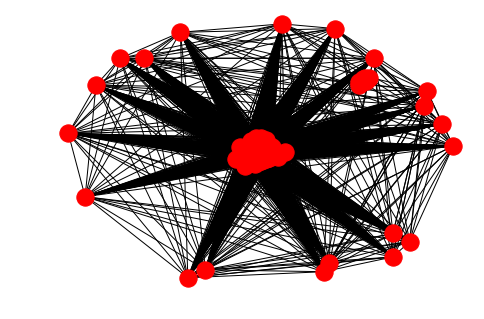

In [112]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.cubical_graph()
for edge in edge_graph:
    node1 = edge[0]
    node2 = edge[1]
    
    if node1 not in G.nodes():
        G.add_node(node1)
    
    if node2 not in G.nodes():
        G.add_node(node2)
for edge, e_weight in edge_graph.items():
    print(edge)
    node1 = edge[0]
    node2 = edge[1]
    
    G.add_edge(node1, node2, weight=e_weight)
    
nx.draw(G)
plt.show()

In [114]:

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

comp_dict = {s:0 for s in s_p_500}

article_num = 0
for article in all_articles:
    doc = nlp(article)
    results = [(X.text, X.label_) for X in doc.ents]
    seen_set = set([])
    for r in results: 
        if r[1] == 'ORG':
            seen_set.add(r[0])
    print(seen_set)
    print(comp_dict['AAPL'])
    article_num += 1
    print("Done with: ", article_num)
comp_dict

{'Amazon', 'Big Blue', 'BRK', 'License Support', 'Microsoft', 'EPS', 'LinkedIn', 'Whole Foods Market', 'Cloud Services', 'IBM', 'NASDAQ', 'Cloud   Services & License Support', 'Cloud License &', "The Motley Fool's", 'Berkshire Hathaway', 'SaaS', 'SEC', 'IaaS', 'Motley', 'BRK-A', 'AMZN', 'Oracle   ', 'YOY', 'Oracle', 'Motley Fool Stock Advisor', 'The Motley Fool', 'Motley Fool', 'Azure, Office 365, Dynamics', 'IaaS/PaaS', 'Grapeshot', 'Berkshire', 'NYSE', 'Nasdaq, Inc.', 'non-GAAP'}
0
Done with:  1
{'InvestorPlace - Stock Market News', 'Micron', 'GE', 'ATVI', 'SNAP', 'MU', 'Wynn Resorts', 'NASDAQ', 'Take-Two Interactive', 'TWTR', 'Activision Blizzard', 'NAND', 'Nvidia', 'CSCO', 'Future Blue Chips', 'the Cisco Systems', 'General Electric', 'TTWO', 'NVDA', 'Snap', 'FB', 'NYSE', 'WYNN', 'Electronic Arts', 'Nasdaq, Inc.'}
0
Done with:  2
{'Global Commercial Services', 'Marriott International', 'Amazon', 'Costco', 'American Express', 'Hilton Worldwide Holdings,', 'SAP Ariba', 'GCS', 'Ariba N

{'Dow', 'Caterpillar Inc', 'Trump', 'Alamo Group Inc', 'Gradall', 'Alamo Group Inc  ', 'Caterpillar', 'Reuters', 'Terex Corp.', 'Gradall Industries Inc', 'Hazelton', 'Terex'}
0
Done with:  39
{'Imperial', 'CIBC', 'Reuters', 'Peabody', 'Exxon Mobil Corp', 'Conservative Party', 'Rival Cenovus Energy  ', 'Husky'}
0
Done with:  40
{'Turner', 'Tuner', 'NFL', 'NBA', 'NCAA', 'MLB', 'Google', 'TNT', 'TWX', 'NIT', 'March Madness', 'CBS CBS  ', 'CBS Sports', 'Apple AAPL  TV', 'Coca-Cola KO  ', 'TBS', 'COF', 'FB', 'AT&T', "Time Warner's", 'Nasdaq, Inc.', 'the Wall Street Journal  ', 'CBS'}
0
Done with:  41
{'Comtech Telecommunications Corp.', 'Trump', 'Zacks', 'Special Report', 'AAPL', 'Cisco Systems Inc.', 'Sprint Corp. S  ', 'Verizon Communications Inc.', 'NOK', 'Nokia Corp.', 'Comtech', 'AT&T', 'Nasdaq, Inc.', 'POLITICO', 'Apple Inc.', 'Mobile World Congress', 'Losers'}
0
Done with:  42
{'iShares', '09/22/2009', 'Healthcare', 'Financials', 'SPY', 'SPDR', 'AAPL', 'IWL', 'Zacks ETF Center', 'Rus

{'E*TRADE  ', 'Goldman Sachs Group', 'FinLife Partners', 'Zacks', 'Stifel Financial Corporation', 'Ladenburg Thalmann Financial Services Inc LTS  ', 'Apple', 'Stifel Financial', "Standard & Poor's Investment Advisory Services", 'Goldman', 'United Capital Financial Partners', 'United Capital', 'CNBC', 'E*TRADE', 'United Capital Financial Advisers', 'The Wall Street Journal', 'Nasdaq, Inc.'}
0
Done with:  76
{'The Motley Fool', 'Motley Fool', 'Motley Fool Stock Advisor', 'Tencent Holdings', 'NFLX', 'Nasdaq, Inc.', 'YouTube', 'the Motley Fool'}
0
Done with:  77
{'MLO-115', 'Tullow Oil', 'Pluspetrol', 'Tecpetrol SA', 'Exxon Mobil Corp', 'Reuters', 'Total SA', 'Wintershall', 'Tullow, Pluspetrol and Wintershall', 'Royal Dutch Shell Plc', 'YPF SA  ', 'Mitsui &Co Ltd  ', 'Qatar Petroleum'}
0
Done with:  78
{"Construction Industries'", 'Axon Enterprise', 'Cat Financial', 'DMC Global', 'The Resource Industries', 'Caterpillar Inc.', 'Asia/Pacific', 'Zacks', 'ALRM', 'SG&A', 'DMC Global Inc.', 'Ala

{'CBOE', 'InvestorPlace - Stock Market News', 'ROKU', 'Apple Arcade', 'AAPL', 'Apple TV+', 'Nike', 'NASDAQ', 'InvestorPlace', 'Apple TV', 'Apple News+', 'NYSE', 'NKE', 'Vital Data:', 'Apple', 'Apple Card', 'Nasdaq, Inc.', 'Roku'}
0
Done with:  110
{'the Industrial Products', 'Zebra TechnologiesZBRA', 'Consensus\n\nZebra Technologies Corporation Price', 'Consensus |', 'Growth', 'VGM Score', 'the Zacks Style Scores', 'Caterpillar CAT', 'VGM Score of B.\n', 'Zebra Technologies', 'ZBRA', 'EPS', 'Rockwell Automation ROK', 'Value', 'the Zacks Consensus Estimate', 'Nasdaq, Inc.', 'the Zacks Industry Rank'}
0
Done with:  111
{'Melita', 'Zacks', 'G New Radio', 'Vertiv', 'Consensus', 'the Ericsson Radio System', 'Strong Buy', 'Cisco Systems', 'NorthStar', 'the Ericsson Radio Site System', 'NOK', 'Nokia Corp.', 'EPS', 'Ericsson', 'Harris Corporation', 'the Zacks Consensus Estimate', 'Nasdaq, Inc.'}
0
Done with:  112
{'Ant Financial', 'Motorola', 'Apple Inc. Quote \n \n ', 'Services', 'Microsoft',

{"China'sHuawei Technologies", '25,834.97', 'Refinitiv', 'Nasdaq', 'GW&K Investment Management', 'S&P', 'Reuters', 'J.C. Penney Co Inc  ', 'NYSE', 'Home Depot Inc  ', 'Huawei', 'Corp  '}
0
Done with:  146
{'the Zacks Consensus Estimate', 'Zacks Industry Rank', 'Computer and Technology', 'GOOGL', 'the Computer and Technology', 'Nasdaq, Inc.', 'Zacks Sector Rank'}
0
Done with:  147
{'E.I. du Pont de Nemours and Company', 'DOW', 'Dividend History', 'Basic Industries', 'Nasdaq, Inc.', 'Zacks Investment Research', "ALB's", 'Albemarle Corporation', 'ALB', 'Dow Chemical Company'}
0
Done with:  148
{'Dow', 'Amazon.com IncAMZN.O', 'Nasdaq', 'SlateStone Wealth LLC', 'Shounak Dasgupta', 'Procter & Gamble', 'Coca-Cola CoKO.N', 'Coke', 'United Technologies CorpUTX.N', 'Reuters', 'S&P', 'Hasbro IncHAS.O', 'NewYork', 'Twitter Inc', 'NYSE', 'United Tech', 'NasdaqComposite'}
0
Done with:  149
{'BA', 'Johnson & Johnson', 'Chevron', 'UL', 'Eli Lilly    ', 'CHL', 'Amgen', 'iPhone', 'CVX', 'JNJ', 'LLY', 'U

{'KTA', 'the United States Oil Fund', 'A.P. M', 'MDR', 'TOT', 'the United States Natural Gas', 'A/S', "Irkutsk Oil Company's", 'OXY', 'CVX', 'FTI', 'BTU', 'Nasdaq, Inc.', 'the New York Mercantile Exchange', 'EQNR'}
0
Done with:  183
{"the Federal Trade Commission's", 'QCOM', 'Motley Fool', 'Motley', 'AAPL', 'Kerrisdale Capital', 'NASDAQ', 'Apple', 'Motley Fool Stock Advisor', 'Nasdaq, Inc.', 'CFA'}
0
Done with:  184
{'The Motley Fool', 'Motley Fool', 'Netflix', 'the U.K. Netflix', 'NFLX', 'Nasdaq, Inc.', 'Motley Fool Stock Advisor'}
0
Done with:  185
{'InvestorPlace - Stock Market News', 'Android', 'InvestorPlace', 'Treasury', 'Jabil', 'Trump', 'AAPL', 'NASDAQ', 'CRNT', 'Apple', 'Google', 'XIACY', 'GOOGL', 'Pixel', 'Ceragon Networks', 'Ceragon', 'NYSE', 'Nasdaq, Inc.', 'JBL'}
0
Done with:  186
{'SunPower', 'Chevron', 'TOT', 'RDS', 'Royal   Dutch Shell', 'Silicon Ranch', 'XOM', 'CVX', 'Renewable Energy Group', 'CO2', 'MP2 Energy', 'DuPont', 'Nasdaq, Inc.', 'Motley Fool Stock Advisor', '

{'PIF', 'Saudi Aramco', 'Bank of America Merrill Lynch', 'Al Arabiya', 'AAA', 'Marwa Rashad', 'Morgan Stanley', 'IPO', 'Goldman Sachs  ', "Alrajhi Capital's", 'SABIC', 'EFG-Hermes', 'Saudi Basic Industries Corp', 'Citigroup', 'Alrajhi Capital', 'Reuters', 'Aramco', 'Rania El Gamal', 'Exxon Mobil', 'the Public Investment Fund'}
0
Done with:  217
{'Hakuhodo DY Holdings', 'SMAP', 'Amazon', 'CyberAgent', 'Netflix', 'Masaru Sugiyama', 'Reuters', 'Dentsu', 'AbemaTV', 'Asahi', 'Arinobu Soga', 'Cyberagent', 'Goldman Sachs'}
0
Done with:  218
{'Morgan Stanley', 'InvestorPlace - Stock Market News', 'WFC', 'MS', 'JPM', 'AAPL', 'Nasdaq, Inc.', 'NASDAQ', 'InvestorPlace', 'iPhone', 'NYSE', 'Principal Financial Group', 'Apple', 'JPMorgan Chase', 'Wells Fargo'}
0
Done with:  219
{'E.I. du Pont de Nemours and Company', 'the SEE Dividend History  ', 'DOW', 'Basic Industries', 'Nasdaq, Inc.', 'Zacks Investment Research', 'Exchange Traded Fund', 'ETF', 'SEE', 'Sealed Air Corporation', 'Dow Chemical Compan

{'Amazon', 'Trump', 'Google', 'GOOGL', 'FB', 'Alphabet Inc.', 'Intel', 'Nasdaq, Inc.', 'FB - Zacks Rank'}
0
Done with:  254
{'Dow Chemical', 'BASF', 'DuPont', 'Zacks', "Zacks'", 'The Chemours Company CC', 'DuPont DD  ', 'Advanced Printing', '&', 'China Print', 'ETF', 'Nasdaq, Inc.', 'E.I. du Pont de Nemours and Company Price'}
0
Done with:  255
{'Nasdaq, Inc.'}
0
Done with:  256
{'the US International Trade Commission', 'Sony', 'QCOM', 'Capital IQ', 'SNE', 'IBM', 'AAPL', 'NTT Docomo', 'Qualcomm Inc.', 'Apple', 'Nasdaq, Inc.', 'SecureWorks'}
0
Done with:  257
{'CSCO', 'Tie \n', 'The Motley Fool', 'PowerPoint', 'SEC', 'Motley Fool', 'LinkedIn', 'NASDAQ', 'ANET', 'Cisco Systems', 'NYSE', 'Microsoft', 'Data', 'Nasdaq, Inc.', 'Motley Fool Stock Advisor', "The Motley Fool's"}
0
Done with:  258
{'The Motley Fool', 'Motley Fool', 'Netflix', 'AAPL', 'DIS', 'NFLX', 'Apple', 'Motley Fool Stock Advisor', 'Nasdaq, Inc.'}
0
Done with:  259
{'Whole Foods Market', 'Amazon', 'Motley Fool', 'Uber Techno

{'NRF', 'American Express', 'the U.S. Giants', 'Walmart WMT  ', 'Macy', 'The National Retail Federation', 'Nasdaq, Inc.', 'Amazon AMZN  ', 'U.S. Treasury', 'Army'}
0
Done with:  290
{'Connected Enterprise', 'Zacks', 'Rockwell Automation', 'Information Solutions', 'VGM Score of A', 'Process', 'Axon Enterprise', 'VGM', 'Caterpillar Inc.', 'Caterpillar', "Rockwell Automation's", 'Connective Services', 'Terex Corporation', 'EPS', 'Rockwell Automation Inc.', 'Nasdaq, Inc.', 'Value', 'the Zacks Consensus Estimate'}
0
Done with:  291
{'InvestorPlace - Stock Market News', 'Nasdaq', 'GE', 'SBUX', 'InvestorPlace', 'Enlarge\n', 'Alphabet', 'NASDAQ', 'Square', 'Home Depot', 'Enlarge\nInvestorPlace', 'Future Blue Chips', 'General Electric', 'HD', 'GOOGL', 'Starbucks', 'TSLA', 'Enlarge\nShares', 'NYSE', 'Nasdaq, Inc.'}
0
Done with:  292
{'GS', 'Consensus', 'Strong Buy', 'Goldman', 'EPS', 'Sell', 'Zacks Earnings', 'the Zacks Consensus Estimate', 'Nasdaq, Inc.', 'the Zacks Consensus EPS', 'Goldman Sac

{'Capital IQ', 'CLS', 'IBM', 'AAPL', 'KLIC', 'EPS', 'Nasdaq, Inc.', 'Changyou.com'}
0
Done with:  324
{'Nasdaq, Inc.'}
0
Done with:  325
{'InvestorPlace - Stock Market News', 'Verizon Communications', 'Amazon', 'Magellan Health', 'InvestorPlace', 'Robert Half International', 'Trump', 'the U.N. Security Council', 'Match Group', 'NASDAQ', 'Magellan', 'Nvidia', 'CSCO', 'AMZN', 'FireEye', 'RHI', 'NVDA', 'Intuit', 'Cisco Systems', 'TLRY', 'AT&T', 'NYSE', 'NBC News', 'Nasdaq, Inc.', 'MTCH'}
0
Done with:  326
{'Nutanix Inc. Price', 'Research', 'EPS', 'Nasdaq, Inc.', 'EPS Surprise \n    \n '}
0
Done with:  327
{'Nasdaq, Inc.'}
0
Done with:  328
{'The Motley Fool', 'Apache', 'Motley Fool', 'XOM', 'BOE', 'APA', 'ExxonMobil', 'CAGR', 'Altus', 'Image', 'HES', 'NYSE', 'Kayne Anderson Acquisition Corp.', 'Nasdaq, Inc.', 'Altus Midstream', 'Motley Fool Stock Advisor', 'Alpine High'}
0
Done with:  329
{'Dow', 'Texas Instruments Inc', 'Nasdaq', 'PT', 'Broadcom Inc', 'Nvidia Corp', 'United Continental H

{'Reuters', 'Airbus', 'WTO', 'The U.S. Trade Representative', 'European Union'}
0
Done with:  358
{'MRO', 'Tecnoglass Inc.', 'Tecnoglass', 'Zacks', 'Pro', 'Lowes.com', 'Lowe', 'LowesForPros.com', 'Home Depot', "Comps & Digital Presence Aid Lowe's", 'GA', 'Nasdaq, Inc.', 'Fastenal Company FAST', 'Growth Strategies & Solid Earnings History Drive Home Depot    ', 'Fastenal'}
0
Done with:  359
{'Nasdaq, Inc.', 'WisdomTree', 'U.S. LargeCap Dividend Fund'}
0
Done with:  360
{'Motley Fool', 'Netflix', 'the Cooking Channel', 'Food Network', 'DIY Network', 'Discovery', 'HGTV', 'NFLX', 'Nasdaq, Inc.', 'Motley Fool Stock Advisor', 'Motley     Fool'}
0
Done with:  361
{'MMM', 'Nasdaq, Inc.', 'Dow Analyst Moves'}
0
Done with:  362
{'CVX', 'Chevron Corporation', "Dividend Channel ''", 'DividendRank', 'Nasdaq, Inc.', 'ETF'}
0
Done with:  363
{'Chevron Corp Common Stock Usd.75', 'Invesco', 'Healthcare', 'Value', 'Cost & Other Expenses\n', 'the Schwab Fundamental', 'XOM', 'AAPL', 'Exxon Mobil Corp Comm

{'BA', 'InvestorPlace - Stock Market News', 'Teamsters', 'GE', 'InvestorPlace', 'FedEx', 'IAM', 'LMT', 'Martin Marietta', 'Lango', 'Trump', 'HSY', 'Pentagon', 'Kisses', 'Pro-Labor Stocks to', 'UPS', 'General Electric', 'AOS', 'Dividend Aristocrat', 'FDX', 'the International Association of Machinists and Aerospace Workers', 'CAT', 'Hershey', 'Lockheed Corporation', 'Amplify Snack Brands', 'Lockheed', 'MMM', 'Caterpillar', 'Skinny', 'NYSE', 'Nasdaq, Inc.', 'U.S. Seventh Circuit Court of Appeals', 'Boeing', 'the AFL-CIO'}
0
Done with:  398
{'Chevron', 'The Philadelphia Oil Service', 'COP', 'XOM', 'Capital', 'CVX', 'Anadarko', 'BTU', 'Occidental Petroleum', 'Occidental', 'Navios Maritime Partners LP', 'NMM', 'Cenovus Energy', 'SLB', 'the United States Oil', 'APC', 'the United States Natural Gas', 'CAD0.61', 'OXY', 'Nasdaq, Inc.'}
0
Done with:  399
{'The Zacks Consensus Estimate', 'Urban Outfitters, Inc', 'Notch', "Amazon.com, Inc.'s", 'Tapestry,', 'the National Retail Federation', 'RHRH', 

{'Dow', 'InvestorPlace - Stock Market News', 'Nasdaq', 'American Express', 'AXP', 'Alibaba Group', 'InvestorPlace', 'Costco Wholesale', 'NYSE', 'Nasdaq, Inc.'}
0
Done with:  426
{'Zacks', 'M', '1 (Strong Buy', 'Danaher Corporation DHR', 'Sell', 'P/E(TTM', 'Nasdaq, Inc.', 'the Zacks Consensus Estimate', 'Altra Industrial Motion Corp.', "3M's", 'Macquarie Infrastructure Company'}
0
Done with:  427
{'InvestorPlace - Stock Market News', 'Fossil \xa0', 'Roth Capital', 'InvestorPlace', 'Fitbit', 'Counterpoint Research', 'EPS', 'FOSL', 'NASDAQ', 'Fitbi', 'FIT', 'Google', 'Fossil', 'Versa', 'Fitbit and Fitbit', 'Pixel', 'Fitbit Health Solutions', "Fitbit Health Solutions'", 'Nasdaq, Inc.'}
0
Done with:  428
{'Surprise \n \n ', 'Mondelez International,', 'Archer-Daniels-Midland Company ADM', 'Mondelez International, Inc.', 'Archer Daniels Midland Company Price', 'Surprise', 'EPS', "the Offing for Archer Daniels'", 'Nasdaq, Inc.', 'the Zacks Consensus Estimate'}
0
Done with:  429
{'SDA', 'IBM', 

{'Motorola', 'Microsoft', 'Guidance & Estimates', 'Notably', 'Hewlett Packard Enterprise', 'The Zacks Consensus Estimate', 'Infrastructure Services', 'Mellanoxhas', 'Zacks', 'Netflix,', 'Ethernet', 'VMware', 'BlueField', 'the Zacks Consensus Estimate', 'GB Ethernet', 'Broadcom', 'Progressive Corporation', 'Strong Buy', 'Microsemi Corporation', 'InfiniBand', 'the Zacks Model Unveils', 'Radical New Technology', 'Sell', 'Intel', 'NFLX', 'RLI Corp.', 'LinkX', 'ConnectX Ethernet', 'Nasdaq, Inc.'}
0
Done with:  458
{'URI', 'Research Wizard', 'Perspecta Inc. PRSP', 'Caterpillar Inc.', 'Money Magazine', 'the Research Wizard', 'the Screen of the Week', 'Zacks Investment Research', 'GARP', 'this Screen of the Week', 'Investopedia', 'Zacks Rank', 'DXC Technology Company DXC', 'PEG', 'United Rentals,', 'Tailored Brands,', 'About Screen of the Week\nZacks.com', 'The Research Wizard', 'Nasdaq, Inc.'}
0
Done with:  459
{'Companies,', "Lowe's Companies,", 'Consensus', 'Lowe', 'EPS', 'Lumber Liquidator

{'InvestorPlace - Stock Market News', 'Amazon', 'Statista', 'Fortnite', 'The Reluctant Detective Finds', 'Apple Arcade', 'Samsung Electronics', 'InvestorPlace', 'Microsoft', 'SNAP', 'AAPL', 'NASDAQ', 'Apple', 'Project xCloud', 'Nvidia', 'Google', 'WMT', 'AMZN', 'MSFT', 'NVDA', 'Sony', 'SNE', 'Snap', 'GeForce Now', 'Final Fantasy', 'Twitch', 'NYSE', 'dp/', 'Electronic Arts', 'Nasdaq, Inc.', 'Playstation'}
0
Done with:  489
{'iPhones', "Apple Inc's", 'IQE Plc  ', 'Reuters'}
0
Done with:  490
{'Amazon', 'Special Report', 'Services', 'United Technologies', 'Notably', 'the Zacks Biomedical and Genetics', 'Xilinx XLNX  ', 'Amgen', 'Amgen & United', 'Technologies  \n', 'the Zacks Equity Research', 'Zacks Investment Research', 'iPhone', 'Apple', 'Zacks Rank', "United Technologies'", 'Amgen AMGN  ', 'Apple Music', 'Travelers Companies', 'Mastercard', "Rockwell Collins'", 'App Store', 'Samsung', 'Apple AAPL  ', 'Rockwell Collins', 'Repatha', 'Research Daily', 'Kyprolis', 'Nasdaq, Inc.', 'Travele

{'BA', 'InvestorPlace - Stock Market News', 'NAFTA', 'InvestorPlace', 'Microsoft', 'USMCA', 'Trump', 'BSX', 'Needham', 'UAL', 'NASDAQ', 'United Airlines', 'CSCO', 'Boston Scientific', 'Honeywell', 'HON', 'CAT', 'Dreamliners', 'DHR', 'Caterpillar', 'NYSE', 'Nasdaq, Inc.', 'Boeing', 'Piper Jaffray'}
0
Done with:  520
{'InvestorPlace - Stock Market News', 'HOLD', 'QCOM', 'Android', 'AAPL', 'NASDAQ', 'SellSpreads.com', 'InvestorPlace', 'Apple Stock Has Plenty More Room to Run', 'SELL', 'Apple', 'BUY', 'Nasdaq, Inc.'}
0
Done with:  521
{'BASF', 'Dow', 'DuPont', 'DOW', 'DD', 'The Dow Chemical Company', 'ADR', 'Nasdaq, Inc.', 'E.I. DuPont de Nemours & Company', '’s'}
0
Done with:  522
{'Google', 'the U.S. Defense Department', 'the Joint Chiefs of Staff', 'Reuters', 'the U.S. Congress', 'Dunford', 'Senate Armed Services Committee'}
0
Done with:  523
{'BA', 'London Exchange', 'Caterpillar', 'EPS', 'Nasdaq, Inc.', 'CAT', 'Boeing'}
0
Done with:  524
{'the Federal Reserve', 'Johnson & Johnson', 'P

{'Stanford Medical School', 'Consensus', 'Consensus \n \n    \n Apple Inc. Price', 'Fitbit', 'HealthKit', 'Notably', 'iPhone', 'ECG', 'Apple Inc. Price', 'Apple', 'Google', 'Watch Series', 'EKG', 'Apple Watch Series 4', 'Beats', 'Samsung', 'Nasdaq, Inc.', 'Apple Watch', 'Apple Inc.'}
0
Done with:  554
{'Dow', 'Nasdaq', 'Walt Disney CoDIS.N', 'Reuters', 'NorthAmerican', 'NYSE', 'Bell Investment Advisors', 'Comcast', 'Boeing', 'Bell'}
0
Done with:  555
{'InvestorPlace - Stock Market News', 'Alphabet', 'Fed', 'StockTwits', 'GOOGL', 'InvestorPlace', 'NYSE', 'Microsoft', 'Nasdaq, Inc.', 'MSFT'}
0
Done with:  556
{'Royal Dutch', 'Lufthansa', 'TF Global Markets', 'Goldman Sachs  ', 'UK) Ltd', 'UniCredit SpA', 'Reuters', 'BP', 'the European Trade', 'STOXX', 'the European Union', 'O/R\nInvestors', 'Citigroup', 'Goldman Sachs'}
0
Done with:  557
{'The Zacks Consensus Estimate', 'W.W. Grainger', 'Zacks', 'Special Report', 'Axon Enterprise', 'Nasdaq, Inc.', 'Place    ', 'Caterpillar', 'ROE', 'Zack

{'Bayaz', 'Goldman Sachs  ', 'Green party', 'Commerzbank', 'Reuters', 'Kukies', 'BERLIN', 'Deutsche Bank', 'Goldman Sachs'}
0
Done with:  583
{'Dow', 'Fed', 'Nasdaq', 'AAPL', 'Trade-Alert    \nOil', 'KO', 'EIA', 'S&P', 'Coca-Colo', 'VIX', 'Apple', 'the Energy Information Administration', 'Nasdaq, Inc.'}
0
Done with:  584
{'The Zacks Consensus Estimate', 'Trump', 'UnitedHealth Group Inc.', 'UNH', 'The Travelers Companies Inc.', 'Cisco Systems Inc.', 'The Travelers Companies', 'UnitedHealth', 'Visa', 'Nasdaq, Inc.', 'Visa Inc.', 'Boeing'}
0
Done with:  585
{'Morgan Stanley', 'Goldman Sachs Group, Inc.', 'JMP Group', 'the JMP Dividend History', 'Zacks Investment Research', 'Finance', 'JMP', 'Nasdaq, Inc.', 'MS'}
0
Done with:  586
{'Digital', 'EPS', 'Shingrix', 'Target', 'XOM', 'Shipt', 'Guyana   ', 'Stabroek', 'Goliath ExxonMobil', 'Motley Fool Stock Advisor', 'Glaxo', 'COPD', 'Motley Fool', 'Consumer Healthcare', 'ExxonMobil', 'Guyana', 'TGT', 'NYSE', 'Nasdaq, Inc.'}
0
Done with:  587
{'

{'YouTube', '@Google', 'Reddit', 'Reuters'}
0
Done with:  618
{'Facebook Inc (Symbol:', 'Verizon Communications Inc', 'Netflix Inc (', 'XLC Holdings', 'XLC', 'ETF Channel  ', '»', 'Nasdaq, Inc.'}
0
Done with:  619
{'BA', 'Android', 'Johnson & Johnson', 'Chevron', 'UL', 'Binnie Wong', 'Eli Lilly    ', 'CHL', 'Whole   Foods', 'Amgen', 'the Bird Box Challenge', 'CVX', 'JNJ', 'LLY', 'FANG', 'UnitedHealth Group', 'CSCO', 'Berkshire Hathaway', 'Nike', 'TSM', 'INTC', 'AMGN', 'UNH', 'Tafamidis', 'JPMorgan Chase', 'PetroChina', 'Bank of America', 'AXP', 'Apple', 'AmEx', "The Motley Fool's", 'Citigroup', 'Wholesale', 'NOV', 'FDA', 'NFLX', 'Mastercard', 'Union Pacific    ', 'Adobe Systems', 'The Motley Fool', 'BAC', 'RDS-A', 'Royal Dutch Shell', 'Salesforce.com', 'AT&T', 'MRK', 'National Oilwell', 'Verizon Communications', 'PayPal Holdings', 'Microsoft', 'NKE', 'UNP', 'LinkedIn', 'Wells Fargo    ', 'Whole Foods Market', 'Alphabet', 'WFC', 'The Washington Post', 'XOM', 'Procter & Gamble', 'CNBC', 

{'The Motley Fool', 'Motley Fool', 'JPMorgan', 'YOY', 'AAPL', "Morgan Stanley's", 'Non-GAAP', 'NASDAQ', 'LIDAR', 'iPhone', 'Lumentum', 'Lumentum Holdings', 'EPS', 'Apple', 'Motley Fool Stock Advisor', 'Nasdaq, Inc.'}
0
Done with:  653
{'E.I. du Pont de Nemours and Company', 'DOW', 'MEOH', 'Basic Industries', 'Dividend History', 'Zacks Investment Research', 'Methanex Corporation', 'Nasdaq, Inc.', 'Dow Chemical Company'}
0
Done with:  654
{'Whole Foods Market', 'Apple.com', 'Amazon', 'Motley Fool', 'Windows', 'The Motley Fool', 'AAPL', 'LinkedIn', 'NASDAQ', 'CFO', 'AMZN', 'Microsoft', 'MediaPad', 'Apple', 'Huawei', 'Motley Fool Stock Advisor', 'Nasdaq, Inc.', "The Motley Fool's"}
0
Done with:  655
{'BA', 'SPX', 'MMM', 'GE', 'GE Capital', 'General Electric', 'Honeywell', 'MDLZ', 'HON', 'Cowen', 'UTX', 'United Technologies', 'ABT', 'Nasdaq, Inc.', '’s', 'Boeing Co.'}
0
Done with:  656
{'Martin Midstream Partners L.P.', 'Nasdaq', 'Utilities\n\n\n', 'Appliance Recycling Centers of America In

{'Dow', 'Home Depot HD', 'MTV', 'the Federal Open Market Committee', 'Tech', 'Macy', 'Pharma', 'Walmart WMT', 'the White House', 'Nasdaq, Inc.'}
0
Done with:  685
{'Zacks', 'the Federal Reserve', 'American Express', 'CCAR', 'Euronet Worldwide,', 'Capital One Financial Corporation', 'Discover Financial Services', 'American Express Co.', 'Nasdaq, Inc.', 'AmEx', 'Euronet Worldwide'}
0
Done with:  686
{'Dow', 'Amazon', 'Advisor', 'South', 'National Inventors Month', 'Post', 'Nebraska', 'BRK', 'The Motley   Fool\xa0', 'MarketFoolery', 'Wells Fargo    ', 'Whole Foods Market', 'WFC', 'Alphabet', 'Salomon', 'NASDAQ', 'SG&A', 'Other Bets\xa0', 'the U.S. Patent', 'the Hall of Fame', 'Apple', 'Google\xa0', "The Motley Fool's", 'Which', 'Berkshire Hathaway', 'Google', 'the Motley Fool Stock', 'Bell   Labs', 'BRK-A', 'Nasdaq, Inc.', 'Buffett', 'the National Inventors Hall of   Fame', 'The Motley Fool', 'Motley Fool', 'MMM', "Wells Fargo's", 'NYSE', 'AT&T', 'Congress', 'Wells Fargo'}
0
Done with:  6

{'8,454.13', 'GuruFocus', 'Dow Jones', "The Standard & Poor's", 'VIX', 'Nasdaq, Inc.'}
0
Done with:  710
{'InvestorPlace - Stock Market News', 'Fed', 'StockTwits', 'Caterpillar', 'InvestorPlace', 'NYSE', 'Nasdaq, Inc.', 'CAT'}
0
Done with:  711
{'InvestorPlace - Stock Market News', 'Google', 'Alphabet', 'Maps', 'NASDAQ', 'GOOGL', 'InvestorPlace', 'Alphabet Inc.', 'Nasdaq, Inc.', 'YouTube'}
0
Done with:  712
{'Zacks', 'Vertiv', 'Consensus', 'Strong Buy', 'Cisco Systems', 'NorthStar', 'the Ericsson Radio Site System', 'NOK', 'Harris Corporation', 'EPS', 'Ericsson', 'Nasdaq, Inc.', 'the Zacks Consensus Estimate', 'Nokia Corporation', 'Ericsson Radio System'}
0
Done with:  713
{'The Trump Administration', 'InvestorPlace - Stock Market News', 'The Reluctant Detective Finds', 'Chevron', 'InvestorPlace', 'Standard Oil of New York', 'Bakken', 'China Petroleum & Chemical', 'OPEC', 'XOM', 'the Department of Energy', 'CVX', 'Oilprice.com', 'Standard Oil of New Jersey', 'SNP', 'Rockefeller', 'Admi

{'SDK', 'Special Report', 'Consensus', 'PayPal', 'Consensus \n      \n Square,', 'Square', 'Omnichannel Payment Platform    ', 'Apple', 'Notably', 'Nasdaq, Inc.'}
0
Done with:  747
{'The Motley Fool', 'Motley Fool', 'Texas Instruments    ', 'American Express', 'Dividend Increase \nAmerican Express', 'Fifth Third Bancorp', 'AXP', 'TXN', 'Dividend Increase', 'NYSE', 'Texas   Instruments', 'Texas Instruments\n', 'Nasdaq, Inc.', 'Texas Instruments', 'Motley Fool Stock Advisor'}
0
Done with:  748
{'Counterpoint Research', 'ERIC', 'Xperias', 'AAPL', 'NASDAQ', 'Sony Ericsson', 'the Xperia X10 Plus', 'Apple', 'Canalys', 'Motley Fool Stock Advisor', 'The Motley Fool', 'Sony', 'the   Arabian Times    ', 'Motley Fool', 'SNE', 'Samsung', 'Sony Mobile', 'CFO', 'Mobile Communications', 'NYSE', 'Ericsson', 'Nasdaq, Inc.'}
0
Done with:  749
{'HSBC', "Austria'sRaiffeisen Bank  ", 'Goldman Sachs', 'Goldman Sachs  ', 'the Joint Directorate of Enforcement', 'AHAB', 'Reuters', 'Commerzbank', 'the General C

{'Dow', 'Nasdaq', 'Shreyashi.Sanyal@thomsonreuters.com', "Global Payments'", 'Microsoft', 'HuaweiTechnologies Co LtdHWT.UL', 'Trump', 'Shreyashi   Sanyal\nTrump', 'Global Payments IncGPN.N', 'Shreyashi Sanyal', 'Apple', 'U.S. Commerce Department', 'the Federal Aviation Administration', 'Reuters', 'Foot Locker IncFL.N', 'ArunKoyyur', 'S&P', 'Decembersell', 'Boeing'}
0
Done with:  788
{'InvestorPlace - Stock Market News', 'NUS', 'Caraustar', 'Clorox', 'InvestorPlace', 'the Nu Skin', 'AAPL', 'Procter & Gamble', 'NASDAQ', 'Nu Skin Enterprises', 'iPhone', 'GEF', 'Apple', 'Compañía Cervecerías Unidas S.A.', 'United Breweries', 'CLX', 'CCU', 'Pharmanex', 'PG', 'NYSE', 'Nasdaq, Inc.'}
0
Done with:  789
{'Stock Options Channel', 'AXP', 'American Express Co.', 'Nasdaq, Inc.', 'YieldBoost'}
0
Done with:  790
{'Finance', 'CFO', 'COO', 'Symantec\xa0', 'Marketing Teams \n \n More Trefis Research \n \n', 'EPS', 'Nasdaq, Inc.', 'Symantec', 'SYMC'}
0
Done with:  791
{'E.I. du Pont de Nemours and Compan

{'InvestorPlace - Stock Market News', 'Amazon', 'YTD', 'Best Buy Co Inc', 'Johnson & Johnson', 'BBY', 'SOHO', 'NFL', 'InvestorPlace', "Johnson & Johnson's", 'BX', 'ETF Trust', 'SPY', 'Blackstone', 'KIM', 'Wells Fargo & Co', 'WFC', 'Kimco Realty Corp', 'NYSEARCA', 'XOM', "Exxon Mobil's", 'DUK', 'Equifax', 'Exxon Mobil Corporation', 'Costco Wholesale Corporation', 'NASDAQ', 'JNJ', 'Buy for Every Investor', 'SeaWorld Entertainment Inc', 'Duke Energy', 'WMT', 'Amazon.com, Inc.', 'AMZN', 'REIT', 'Blackstone Group LP', 'Equifax Inc', 'TipRanks', 'AT&T Inc', 'Welltower Inc', 'Wal-Mart Stores Inc', 'Duke Energy Corp', 'NYSE', 'AT&T', 'Welltower', 'Nasdaq, Inc.', 'T. Visit', 'Wells Fargo'}
0
Done with:  823
{'The Motley Fool', 'Hulu', "DISH Network's Sling TV", 'Motley Fool', 'Hulu Live', 'Motley Fool Stock Advisor', 'DIRECTV', 'UBS', "Motley Fool's", 'ARPU', 'YouTube TV', 'AT&T', 'NYSE', 'Nasdaq, Inc.', 'YouTube'}
0
Done with:  824
{'Coca-Cola', 'Nasdaq, Inc.', 'Coke', 'KO', 'EPS', 'Coca-Cola’

{'InvestorPlace - Stock Market News', 'Honeywell International Inc.', 'General Electric Company Stock', 'United Technologies Corporation', 'MMM', 'GE', 'General Electric', 'InvestorPlace', 'Eastman Kodak Company', 'HON', 'NYSE', 'Siemens AG', 'Nasdaq, Inc.', 'General Electric Company'}
0
Done with:  857
{'Amazon', 'Google', 'Netflix', 'AAPL', 'UBS', 'FAANG', 'FB', 'AMZN', 'Bleakley Advisory Group', 'CNBC', 'NFLX', 'Apple', 'Nasdaq, Inc.'}
0
Done with:  858
{'InvestorPlace - Stock Market News', 'InvestorPlace', 'UNP', 'Bank of America', 'WFC', 'AAPL', 'GS', 'NASDAQ', 'iPhone', 'Apple', 'KHC', 'Berkshire Hathaway', 'Goldman', 'Nasdaq, Inc.', 'BAC', 'JPM', 'NYSE', 'Kraft Heinz', 'JPMorgan Chase', 'Union Pacific', 'Wells Fargo', 'COO', 'Goldman Sachs'}
0
Done with:  859
{'Dow', 'Rand Paul', 'GOP', 'UPSIDE', 'Keywords International', 'EPS', 'INVE', 'PTI-125\n', 'Trump', 'CNBC', 'FANG', 'HNI', 'VISI', 'Completed', 'IMDZ', 'Nasdaq, Inc.', 'WHR', 'Fed', 'MMM', 'Sells QA', 'Caterpillar', 'China

{'Refinitiv', 'Salesforce', 'Qualtrics International', 'Reuters', 'FactSet', 'SAP', "Microsoft Corp's", 'Salesforce.com', 'Microsoft', 'IBES', 'MuleSoft', 'Oracle'}
0
Done with:  887
{'E.I. du Pont de Nemours and Company', 'CE', 'DOW', 'Dividend History', 'Basic Industries', 'Zacks Investment Research', 'Celanese Corporation (\nCE', 'Nasdaq, Inc.', 'Dow Chemical Company'}
0
Done with:  888
{'E.I. du Pont de Nemours and Company', 'the EMN Dividend History  ', 'DOW', 'Basic Industries', 'Zacks Investment Research', 'Eastman Chemical Company', 'Nasdaq, Inc.', 'EMN', 'Dow Chemical Company'}
0
Done with:  889
{'Dow Chemical', 'Dow', 'DuPont', 'EC', 'The Chemours Company CC', 'The European Commission', "DuPont's", 'EPS', 'Nasdaq, Inc.', 'the Zacks Consensus Estimate', 'Teck Resources Limited TCK', 'DE Price'}
0
Done with:  890
{'Bitcoin ABC', 'Goldman Sachs GS', 'The Bitcoin Investment Trust', 'Bitcoin SV', 'KPMG', 'Square SQ', 'Nasdaq, Inc.', 'Bitcoin Cash'}
0
Done with:  891
{'WMT', 'Dow M

{"the GS Bank's", 'M&T Bank Corporation MTB  ', 'SunTrust Banks,', 'Special Report', 'GE Capital Bank', '1 (Strong Buy', 'ROE', 'Goldman', 'EPS', 'ETF', 'Apple', 'Notably', 'Nasdaq, Inc.', 'Steady Capital Deployment', 'Goldman Sachs'}
0
Done with:  926
{'Beacon Roofing Supply', 'S&P', 'The Home Depot', 'Nasdaq, Inc.', 'Want Better-Ranked Building Products - Retail Stocks'}
0
Done with:  927
{'BA', 'the iShares Global Industrials ETF', 'EXI', 'MMM', 'General Electric', 'GE', 'Zacks ETF Center', 'ETF', 'Nasdaq, Inc.', 'Boeing'}
0
Done with:  928
{'Starbucks Corporation', 'the NASDAQ Stock Exchange', 'AAPL', 'NASDAQ', 'SBUX', 'The Kraft Heinz Company', 'Dow Jones', 'CVX', 'Chevron Corporation', 'Nasdaq, Inc.', 'KHC', 'Apple Inc.'}
0
Done with:  929
{'The Motley Fool', 'Motley Fool', 'Netflix', 'AAPL', "Motley Fool's", 'GOOGL', 'NFLX', 'Apple', 'Motley Fool Stock Advisor', 'Nasdaq, Inc.', 'CFA'}
0
Done with:  930
{'nVent Electric', 'Water and Electrical - Pentair', 'HEES', 'Avery Dennison 

{'NetScout Systems, Inc.', 'Zacks Computer And Technology Sector', 'LTE', 'EPS', 'Zacks Best EV Stock Free', 'Zacks', 'The Zacks Consensus Estimate', 'The Zacks Computer - Networking', 'Ethernet', "the Zacks Computer - Networking Industry's", 'Zacks Industry Rank', 'the Computer - Networking', 'The Zacks Computer - Networking Industry', 'The Zacks Computer and Technology Sector', 'AI', 'Zacks Computer And Technology', 'the Zacks Computer - Networking', 'CSCO', 'VR', 'Computer - Networking', 'P/S', 'Sell', 'The Zacks Computer - Networkingindustry', 'Stretched Valuation a', 'The Computer - Networking', 'NETGEAR, Inc.', 'NTGR', 'Computer Networking', 'IP', 'Zacks Industry', '/S', 'Cisco Systems,', 'NTCT', 'Nasdaq, Inc.'}
0
Done with:  960
{'Morgan Stanley', 'IAI', 'Nasdaq,', 'Goldman Sachs Group,', 'Finance', 'Zacks Investment Research', 'Exchange Traded Fund', 'MS  ', 'ETF', 'Nasdaq, Inc.', 'NDAQ'}
0
Done with:  961
{'MGM', 'JPMorgan    ', 'American Express', 'Nasdaq', 'Procter & Gamble'

{'Berkshire Hathaway', 'Google', 'Media', 'MSFT  Azure', 'Amazon', 'The Oracle of Omaha', 'Coca-Cola KO  ', 'Reuters', 'AMZN', 'iPhone', 'Microsoft', 'CNBC', 'Wells Fargo WFC  ', 'Apple', 'Bank of America', 'Nasdaq, Inc.'}
0
Done with:  997
{'Motley Fool', 'Motley Fool Stock Advisor', 'SaaS   ', 'Hewlett-Packard Enterprise', 'Nasdaq, Inc.', 'PaaS/IaaS', 'Cisco Systems', 'NYSE', 'Services', 'Cisco', 'Oracle', 'Motley     Fool', 'Security'}
0
Done with:  998
{'The Motley Fool', 'Motley Fool', 'AAPL', 'NASDAQ', 'iPhone', 'Apple', 'Apple Watch', 'Motley Fool Stock Advisor', 'Nasdaq, Inc.', 'Beats', 'AirPods'}
0
Done with:  999
{'Disney', 'Alphabet', 'Google', 'Fed', 'Facebook FB  ', 'The Walt Disney Company', 'Apple AAPL  ', 'GOOGL', 'Twitter,', 'TWTR', 'Alphabet Inc.', 'EPS', 'Apple', 'Nasdaq, Inc.', 'the Zacks Consensus EPS'}
0
Done with:  1000
{'The Coca-Cola Company KO', 'Zacks', 'Coca-Cola', 'PepsiCo, Inc.', 'Alphabet Inc. GOOGL', 'PepsiCois', 'PepsiCo', 'P/S', 'Verizon Communications

{'PIF', 'Morgan Stanley', 'HSBC', 'JPMorgan', 'Shell', 'Goldman Sachs  ', 'Reuters', 'Exxon', 'National Commercial Bank', 'SABIC', "Saudi Arabia'sPublic Investment Fund", 'Saudi Basic Industries Corp'}
0
Done with:  1028
{'Zacks', "Goldman Sachs'", 'JPMorgan', 'JPM', 'Citigroup C', 'Backed', 'Special Report', 'Apple', 'Goldman', 'EPS', 'Sell', 'Wells Fargo WFC  ', 'the Zacks Consensus Estimate', 'Nasdaq, Inc.', 'The Goldman Sachs Group'}
0
Done with:  1029
{'Dow', 'OPEC', 'the Organization of the Petroleum Exporting Countries', 'Caterpillar', 'Macy', 'Home Depot', 'VIX', 'Nasdaq, Inc.'}
0
Done with:  1030
{"McDonald's Corp", 'the XLY Holdings', 'XLY', '»', 'ETF Channel  ', 'Nike', 'Home Depot Inc', 'NKE', 'Nasdaq, Inc.', 'MCD'}
0
Done with:  1031
{'Dow Chemical', 'Yahoo Finance', 'Trump', 'Fund Newsletter', 'E. I. du Pont de Nemours DD', 'Rio Tinto Plc', 'The U.S. Commerce Department', 'SLX', 'the NYSE Arca Steel', 'XLB', 'VanEck Vectors Steel ETF', "the White House's", 'the Commerce D

{'Dow', 'Outlook \n', 'Comps Up', 'Coca-Cola', 'Walmart', 'Chevron', 'TOT', 'FOMC', 'the U.S. Presidential Elections of', 'Merck', 'PNG LNG', 'EPS', 'LNG', 'Zacks', 'Cavatak', 'Pentagon', "The Coca-Cola Company  's", 'Walmart Inc.', 'The Travelers Companies,', 'CVX', 'P&C', 'Merck & Co.', 'Chevron Corporation', 'the Zacks Consensus Estimate', 'WMT', 'SEC', 'the Federal Open Market Committee', 'Viralytics', 'Coca-Cola Shares Rally on Q4 Earnings & Revenue Beat  ', 'KO', 'Reuters', 'Securities and Exchange Commission', 'Goldman', 'Expand Capacity', 'Kurdistan Operations', 'Fed', 'Quantum Home 2.0', 'ExxonMobil', 'Viralytics Limited', 'Total SA', 'MRK', 'Nasdaq, Inc.', 'U.S. Treasury', 'Oil Search Ltd. ExxonMobil'}
0
Done with:  1053
{'Nexstar Broadcasting Group', 'Netflix', 'PEG', 'Netflix (NFLX', 'the Broadcast Radio and Television', 'NXST', 'NFLX', 'Nasdaq, Inc.', 'Value', 'F.\nNXST'}
0
Done with:  1054
{'Dow', 'Morgan Stanley', 'Refinitiv', 'Cherry Lane Investments', 'Fed', 'Wells Far

{'Honeywell International Inc  ', 'Caterpillar Inc  ', 'United Parcel Service Inc', 'Post', 'Scotch', 'Reuters', 'Honeywell', 'Melius Research', 'Roman', 'CNBC'}
0
Done with:  1086
{'Nasdaq, Inc.'}
0
Done with:  1087
{'AAPL', 'Nasdaq, Inc.', 'Apple Inc (Symbol:'}
0
Done with:  1088
{'Dow', 'Facebook Inc  ', 'Nasdaq', 'Bank of America Merrill Lynch', '25,562.65', 'Chevron Corp  ', '— Microsoft Corp', 'Amazon.com Inc  ', 'OPEC', 'Apple Inc  ', 'the European Central Bank', 'iPhone', 'Reuters', 'Instinet', 'Gradient Investments', 'S&P', 'NYSE', 'Congress', 'Boeing', 'Exxon Mobil Corp  '}
0
Done with:  1089
{'Milacron Holdings Corp.', 'W.W. Grainger', 'Zacks', 'Special Report', 'Axon Enterprise', 'Caterpillar', 'Zacks Rank & Stocks', 'Apple', 'Caterpillar Inc.', 'Nasdaq, Inc.'}
0
Done with:  1090
{'E.I. du Pont de Nemours and Company', 'DOW', 'Basic Industries', 'Zacks Investment Research', 'Orion Engineered Carbons S.A', 'Nasdaq, Inc.', 'OEC', 'Dow Chemical Company'}
0
Done with:  1091
{'T

{'Nasdaq, Inc.', 'Most Active Call & Put Options', 'Booking Holdings Inc', 'BKNG'}
0
Done with:  1126
{'Dow', 'CBOE', 'Fed', "McDonald's", 'IBM', 'MMM', 'the Nasdaq Composite', 'VIX', 'Nasdaq, Inc.', 'MCD'}
0
Done with:  1127
{'TSLA', 'Tesla, Inc.', 'the NASDAQ Stock Exchange', 'AVGO', 'XOM', 'NASDAQ', 'Exxon Mobil Corporation', 'Dow Jones', 'Nasdaq, Inc.', 'The Travelers Companies, Inc.', 'Broadcom Inc.'}
0
Done with:  1128
{'WMT', 'Coca-Cola', 'Harley-Davidson', 'Capital', 'Coke', 'HOG', 'EPS', 'Nasdaq, Inc.', 'MCD', 'JetBlue Airways'}
0
Done with:  1129
{'Dow', 'InvestorPlace - Stock Market News', 'BA', 'the Federal Reserve', 'Chevron', 'VGM Score', 'InvestorPlace', 'Bank of America', 'Disney', 'The Zacks Consensus Estimate', 'GS', 'CVX', 'the Zacks Consensus Estimate', 'Citigroup', 'Chevron Corporation \xa0', 'Strong Buy)', 'VGM Score of A.', 'Intel', 'XLF', 'Nasdaq, Inc.', 'CAT', 'INTC', 'JPM', 'BAC', 'Caterpillar', 'XLI', 'NYSE', 'JPMorgan Chase', 'Boeing', 'Goldman Sachs'}
0
Don

{'Morgan Stanley', "Morgan   Stanley's", 'Motley Fool', 'Bank of America', 'BAC', "Morgan Stanley's", 'GS', 'Goldman', 'NYSE', 'EPS', 'Nasdaq, Inc.', 'Wealth', 'Motley Fool Stock Advisor', 'MS'}
0
Done with:  1161
{'PayPal Holdings Inc.', 'PayPal Holdings', 'the   U.S. Census Bureau', 'EPS', 'American Express', 'Mastercard and PayPal Holdings', 'AXP', 'AmEx', 'American Express Company', 'Motley     Fool', 'the Tax Cuts', 'PayPal', 'Big Data', 'Goldman Sachs U.S. Financial   Services', 'Mastercard', 'Motley Fool Stock Advisor', 'Motley Fool', 'Visa', 'NYSE', 'Nasdaq, Inc.', 'non-GAAP', 'PayPal   '}
0
Done with:  1162
{'Nasdaq, Inc.', 'NKE'}
0
Done with:  1163
{'Dow', 'BA', 'SKX', 'the Market Vectors Gold Miners ETF', 'Microsoft', 'St. Louis Fed', 'EPS', 'Trump', 'the United States Oil Fund', 'IPO', 'AAPL', 'the United States Natural Gas Fund', 'The iShares Silver Trust', 'BTU', 'Apple', 'Galinpepimut-S', 'BMW', 'SPDR Gold Shares', 'FTD', 'NYSE Energy', 'EU', 'Honeywell', 'HON', 'SLS', '

{'SunTrust Robinson', 'Apple Arcade', 'Apple TV Plus', 'CarGurus', 'AAPL – Research Report', 'Apple News', 'Apple News Plus', 'AutoDesk,', 'Oppenheimer', 'ADSK', 'Apple', 'Powell', 'Apple,', 'AutoDesk', 'Apple TV', 'Autodesk', 'CARG', 'Track Record & Ratings', 'TipRanks', 'BuildingConnected', 'Uerkwitz', 'Nasdaq, Inc.', 'Goldman Sachs'}
0
Done with:  1192
{'Disney', 'Facebook Inc  ', 'Amazon.com Inc  ', 'Walt Disney', 'Google', 'Amazon', 'Refinitiv', 'Netflix', 'Walt Disney Co', 'Reuters', 'FANG', 'Alphabet Inc  '}
0
Done with:  1193
{'Nasdaq, Inc.', 'GS', 'Goldman Sachs Group Inc', 'Most Active Call & Put Options'}
0
Done with:  1194
{'Verizon Communications', 'Straight Path', 'Nokia', 'Microsoft', 'CHL', 'Bank of America', 'G', 'NXPI', 'ERIC', 'AVGO', 'Vodafone Group', 'AppDynamics', 'Idea Cellular', 'Warner Brothers', 'Alcatel Lucent', 'CSCO', 'Jasper Technologies', 'Broadcom', 'VOD', 'TNT', 'TWX', 'HBO', 'Dividend Aristocrat', 'Yahoo', 'Vodafone', 'NOK', 'Intel', 'MSFT', 'Ericsson'

{'Amazon', 'Search &', 'Study Watch', 'Microsoft', 'EPS', 'EPS Surprise \n \n    \n ', 'Alphabet', 'Zacks', 'Android OS', 'Twitter TWTR  ', 'Verily', 'ECG', 'ML', 'Google', 'Alphabet Inc. Price', 'Strong Buy', 'FDA', 'Sell', 'Waymo One', 'Walgreens Boots Alliance', 'ResMed', 'Nasdaq, Inc.'}
0
Done with:  1226
{'Aerospace', 'Jason', "Ethiopia'sTransport Ministry", 'MAX', 'NASA', 'Boeing Field', 'Leeham News', 'Reuters', 'Norwegian Air', 'National Transportation Safety Board', 'Ethiopian Transport Ministry', 'Lion Air', 'The U.S. Federal Aviation Administration', 'Ethiopian Airlines', 'FAA', 'Boeing', 'MCAS'}
0
Done with:  1227
{'U.S. Federal Reserve', 'Dow', 'the Federal Reserve', 'Money Map Press', 'DOW', 'S&P', 'NPR', 'Premium Report', 'FOXBusiness', 'CNBC', 'VIX', 'Moneymorning.com', 'Nasdaq, Inc.', 'Rights Reserved', 'Dow Chemical Co.'}
0
Done with:  1228
{'E.I. du Pont de Nemours and Company', 'Quaker Chemical Corporation', 'DOW', 'Dividend History', 'Basic Industries', 'Zacks Inve

KeyboardInterrupt: 

In [ ]:
'''
tickers = ['IBM']
num_pages_to_read = 120
all_articles = get_all_articles(tickers, num_pages_to_read)
'''

In [ ]:
'''
ticker = tickers[0]
save_articles_to_files(all_articles, ticker)
'''

In [ ]:
'''
ticker_dictionary = {
    'GOOGL':set(['Google', 'Alphabet', 'GOOGL', 'googl', 'google']),
    'NFLX':set(['Netflix', 'NFLX', 'netflix', 'nflx']), 
    'MSFT':set(['MSFT', 'Microsoft', 'microsoft', 'MICROSOFT', 'msft']), 
    'AMZN':set(['AMZN', 'Amazon', 'amazon', 'amzn']), 
    'TSLA':set(['TSLA', 'TESLA', 'Tesla', 'tesla', 'tsla'])
}


dow_info = pd.read_html('https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI')[0]['Symbol']
dow_tickers = [t for t in dow_info]
ticker_dictionary = {t:set([t]) for t in dow_tickers}

name_to_ticker = {}
for k, v, in ticker_dictionary.items():
    for name in v: 
        name_to_ticker[name] = k 
'''

In [ ]:
'''
import itertools 
edges = itertools.combinations(ticker_dictionary.keys(), 2)
edge_graph = {e:0 for e in edges}
num_pages_to_read = 100

all_articles = get_all_articles(ticker_dictionary.keys(), num_pages_to_read)

article_num = 0
for article in all_articles: 
    article_num += 1
    company_set = get_company_set(article, ticker_dictionary, name_to_ticker)
    update_graph(edge_graph, company_set)

    
print(edge_graph)
'''

In [ ]:
'''
results = [(v, k) for k, v in edge_graph.items()]
results = sorted(results, reverse=True)
print(results)
'''